In [1]:
# Setup
import pandas as pd
import numpy as np
import os
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load keypoints

In [2]:
subjects = np.load("{}/preprocessing/poseformer/subjects.npy".format(homedir))
keypoints2d = np.load("{}/preprocessing/poseformer/joints_2d_padded.npy".format(homedir))
print(keypoints2d.shape)

(384, 1511, 17, 2)


In [3]:
num_samples = keypoints2d.shape[0]
keypoints2d = keypoints2d.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
df_kp2d = pd.DataFrame(keypoints2d)
df_kp2d.insert(0, 'subjectid', subjects)

df_kp2d

subjectid           0            1           2            3  \
0                  kEC7G8DP  315.685852   753.182617  274.055603   758.386353   
1                  GjPHiGli  456.260345   829.245667  393.725159   844.879456   
2                  RFibHPt7  112.074158   559.071594  126.040131   568.382263   
3                  gO7Cpt1X  184.985413   261.598724  169.771530   257.795258   
4                  xEIsrkiR  260.938232   641.753784  168.722412   641.753784   
..                      ...         ...          ...         ...          ...   
379  VID_20230506_175810340  558.194092   756.626953  447.130249   781.307861   
380                8elUiJYv  535.904724  1174.302490  487.117706  1182.433594   
381  PXL_20230505_234002299  412.282166   884.938721  348.439545   906.219543   
382                q8FyLMSn  251.466553   714.515015  204.084229   734.821716   
383                pmYdj2Zc  328.295410   694.073730  328.295410   718.115417   

              4            5           6            7           8  ...  51364  \
0    378.131226   831.239319  326.093414  1018.575378  357.316101  ...    0.0   
1    581.330688   938.682251  534.429321  1235.724365  518.795532  ...    0.0   
2    247.078568   605.624817  247.078568   754.595215   98.108185  ...    0.0   
3    136.808105   283.151733  152.021988   333.864685  200.199295  ...    0.0   
4    298.909454   771.940796  179.571335   880.429993  353.154053  ...    0.0   
..          ...          ...         ...          ...         ...  ...    ...   
379  521.172852  1250.244263  521.172852  1447.691162  669.257996  ...    0.0   
380  600.954102  1361.319336  584.691772  1670.303955  584.691772  ...    0.0   
381  348.439545  1204.151611  433.563019  1374.398560  476.124756  ...    0.0   
382  244.697662   843.124207  258.235474  1046.191284  298.848877  ...    0.0   
383  256.170410   910.448730  292.232910  1042.677856  328.295410  ...    0.0   

     51365  51366  51367  51368  51369  51370  51371  51372  51373  
0      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
..     ...    ...    ...    ...    ...    ...    ...    ...    ...  
379    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
380    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
381    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
382    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
383    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[384 rows x 51375 columns]

### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

subjectid  OA_check
0    kGhQ1FQc         1
1    KyINSk8e         0
2    ybGzWMPA         0
3    b632WDpF         0
4    UDXlpEgF         0
..        ...       ...
400  tFSyXitq         1
401  OuYG4U64         0
402  nM7tQcBS         0
403  zN0O4jLu         0
404  ESzlIzyO         0

[405 rows x 2 columns]

### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId - precalculated features only
df_join = df_kp2d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

0            1           2            3  \
subjectid                                                                  
kEC7G8DP                315.685852   753.182617  274.055603   758.386353   
GjPHiGli                456.260345   829.245667  393.725159   844.879456   
RFibHPt7                112.074158   559.071594  126.040131   568.382263   
gO7Cpt1X                184.985413   261.598724  169.771530   257.795258   
xEIsrkiR                260.938232   641.753784  168.722412   641.753784   
...                            ...          ...         ...          ...   
VID_20230506_175810340  558.194092   756.626953  447.130249   781.307861   
8elUiJYv                535.904724  1174.302490  487.117706  1182.433594   
PXL_20230505_234002299  412.282166   884.938721  348.439545   906.219543   
q8FyLMSn                251.466553   714.515015  204.084229   734.821716   
pmYdj2Zc                328.295410   694.073730  328.295410   718.115417   

                                 4            5           6            7  \
subjectid                                                                  
kEC7G8DP                378.131226   831.239319  326.093414  1018.575378   
GjPHiGli                581.330688   938.682251  534.429321  1235.724365   
RFibHPt7                247.078568   605.624817  247.078568   754.595215   
gO7Cpt1X                136.808105   283.151733  152.021988   333.864685   
xEIsrkiR                298.909454   771.940796  179.571335   880.429993   
...                            ...          ...         ...          ...   
VID_20230506_175810340  521.172852  1250.244263  521.172852  1447.691162   
8elUiJYv                600.954102  1361.319336  584.691772  1670.303955   
PXL_20230505_234002299  348.439545  1204.151611  433.563019  1374.398560   
q8FyLMSn                244.697662   843.124207  258.235474  1046.191284   
pmYdj2Zc                256.170410   910.448730  292.232910  1042.677856   

                                 8            9  ...  51365  51366  51367  \
subjectid                                        ...                        
kEC7G8DP                357.316101   747.978821  ...    0.0    0.0    0.0   
GjPHiGli                518.795532   813.611877  ...    0.0    0.0    0.0   
RFibHPt7                 98.108185   549.760925  ...    0.0    0.0    0.0   
gO7Cpt1X                200.199295   265.402191  ...    0.0    0.0    0.0   
xEIsrkiR                353.154053   641.753784  ...    0.0    0.0    0.0   
...                            ...          ...  ...    ...    ...    ...   
VID_20230506_175810340  669.257996   731.946106  ...    0.0    0.0    0.0   
8elUiJYv                584.691772  1166.171265  ...    0.0    0.0    0.0   
PXL_20230505_234002299  476.124756   863.657837  ...    0.0    0.0    0.0   
q8FyLMSn                298.848877   694.208313  ...    0.0    0.0    0.0   
pmYdj2Zc                328.295410   670.032043  ...    0.0    0.0    0.0   

                        51368  51369  51370  51371  51372  51373  OA_check  
subjectid                                                                   
kEC7G8DP                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
GjPHiGli                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
RFibHPt7                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
gO7Cpt1X                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
xEIsrkiR                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
...                       ...    ...    ...    ...    ...    ...       ...  
VID_20230506_175810340    0.0    0.0    0.0    0.0    0.0    0.0       NaN  
8elUiJYv                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
PXL_20230505_234002299    0.0    0.0    0.0    0.0    0.0    0.0       NaN  
q8FyLMSn                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
pmYdj2Zc                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  

[384 rows x 51375 columns]

In [6]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

0            1           2            3  \
subjectid                                                                  
kEC7G8DP                315.685852   753.182617  274.055603   758.386353   
GjPHiGli                456.260345   829.245667  393.725159   844.879456   
RFibHPt7                112.074158   559.071594  126.040131   568.382263   
gO7Cpt1X                184.985413   261.598724  169.771530   257.795258   
xEIsrkiR                260.938232   641.753784  168.722412   641.753784   
...                            ...          ...         ...          ...   
VID_20230506_175810340  558.194092   756.626953  447.130249   781.307861   
8elUiJYv                535.904724  1174.302490  487.117706  1182.433594   
PXL_20230505_234002299  412.282166   884.938721  348.439545   906.219543   
q8FyLMSn                251.466553   714.515015  204.084229   734.821716   
pmYdj2Zc                328.295410   694.073730  328.295410   718.115417   

                                 4            5           6            7  \
subjectid                                                                  
kEC7G8DP                378.131226   831.239319  326.093414  1018.575378   
GjPHiGli                581.330688   938.682251  534.429321  1235.724365   
RFibHPt7                247.078568   605.624817  247.078568   754.595215   
gO7Cpt1X                136.808105   283.151733  152.021988   333.864685   
xEIsrkiR                298.909454   771.940796  179.571335   880.429993   
...                            ...          ...         ...          ...   
VID_20230506_175810340  521.172852  1250.244263  521.172852  1447.691162   
8elUiJYv                600.954102  1361.319336  584.691772  1670.303955   
PXL_20230505_234002299  348.439545  1204.151611  433.563019  1374.398560   
q8FyLMSn                244.697662   843.124207  258.235474  1046.191284   
pmYdj2Zc                256.170410   910.448730  292.232910  1042.677856   

                                 8            9  ...  51365  51366  51367  \
subjectid                                        ...                        
kEC7G8DP                357.316101   747.978821  ...    0.0    0.0    0.0   
GjPHiGli                518.795532   813.611877  ...    0.0    0.0    0.0   
RFibHPt7                 98.108185   549.760925  ...    0.0    0.0    0.0   
gO7Cpt1X                200.199295   265.402191  ...    0.0    0.0    0.0   
xEIsrkiR                353.154053   641.753784  ...    0.0    0.0    0.0   
...                            ...          ...  ...    ...    ...    ...   
VID_20230506_175810340  669.257996   731.946106  ...    0.0    0.0    0.0   
8elUiJYv                584.691772  1166.171265  ...    0.0    0.0    0.0   
PXL_20230505_234002299  476.124756   863.657837  ...    0.0    0.0    0.0   
q8FyLMSn                298.848877   694.208313  ...    0.0    0.0    0.0   
pmYdj2Zc                328.295410   670.032043  ...    0.0    0.0    0.0   

                        51368  51369  51370  51371  51372  51373  OA_check  
subjectid                                                                   
kEC7G8DP                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
GjPHiGli                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
RFibHPt7                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
gO7Cpt1X                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
xEIsrkiR                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
...                       ...    ...    ...    ...    ...    ...       ...  
VID_20230506_175810340    0.0    0.0    0.0    0.0    0.0    0.0       1.0  
8elUiJYv                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
PXL_20230505_234002299    0.0    0.0    0.0    0.0    0.0    0.0       1.0  
q8FyLMSn                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  
pmYdj2Zc                  0.0    0.0    0.0    0.0    0.0    0.0       0.0  

[384 rows x 51375 columns]

#### Data validation 

In [7]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [8]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [9]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 83
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 79% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 8

384
83.0
306
67.0
39
8.0
39
8.0


#### Normalization

In [10]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np) + 0.00001) # for numerical stability
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [11]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [12]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 51374]) torch.Size([64])
tensor([[-1.2745, -1.3681, -1.1873,  ..., -0.0573, -0.0573, -0.0573],
        [ 3.9924,  0.0783,  4.3924,  ..., -0.0573, -0.0573, -0.0573],
        [ 0.1618,  0.4525,  0.1609,  ..., -0.0573, -0.0573, -0.0573],
        ...,
        [ 1.8840,  0.9119,  1.7830,  ..., -0.0573, -0.0573, -0.0573],
        [-1.3060, -1.7336, -1.2141,  ..., -0.0573, -0.0573, -0.0573],
        [ 0.1958, -0.5310,  0.4734,  ..., -0.0573, -0.0573, -0.0573]],
       dtype=torch.float64) tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])


#### Create dataloaders with upsampling 

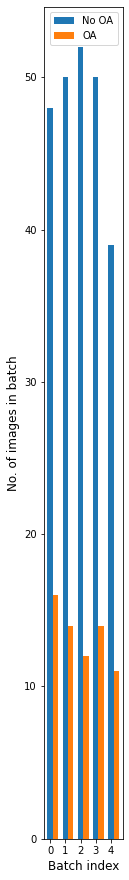

TypeError: cannot unpack non-iterable NoneType object

In [13]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

In [ ]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with unnormalized inputs, no oversampling, weighted loss

Epoch 0, loss = 15.3092, train_acc = 58.8235, val_acc = 64.1026, train_pos = 41.5033, val_pos = 41.0256
Epoch 0, Average Validation F1 Score: 0.4166666666666667
Epoch 10, loss = 3.3373, train_acc = 64.3791, val_acc = 64.1026, train_pos = 39.2157, val_pos = 30.7692
Epoch 10, Average Validation F1 Score: 0.3
Epoch 20, loss = 1.0532, train_acc = 72.8758, val_acc = 58.9744, train_pos = 35.9477, val_pos = 30.7692
Epoch 20, Average Validation F1 Score: 0.2
Epoch 30, loss = 2.4285, train_acc = 71.8954, val_acc = 64.1026, train_pos = 40.1961, val_pos = 30.7692
Epoch 30, Average Validation F1 Score: 0.3
Epoch 40, loss = 1.0155, train_acc = 76.7974, val_acc = 82.0513, train_pos = 38.5621, val_pos = 17.9487
Epoch 40, Average Validation F1 Score: 0.5333333333333333


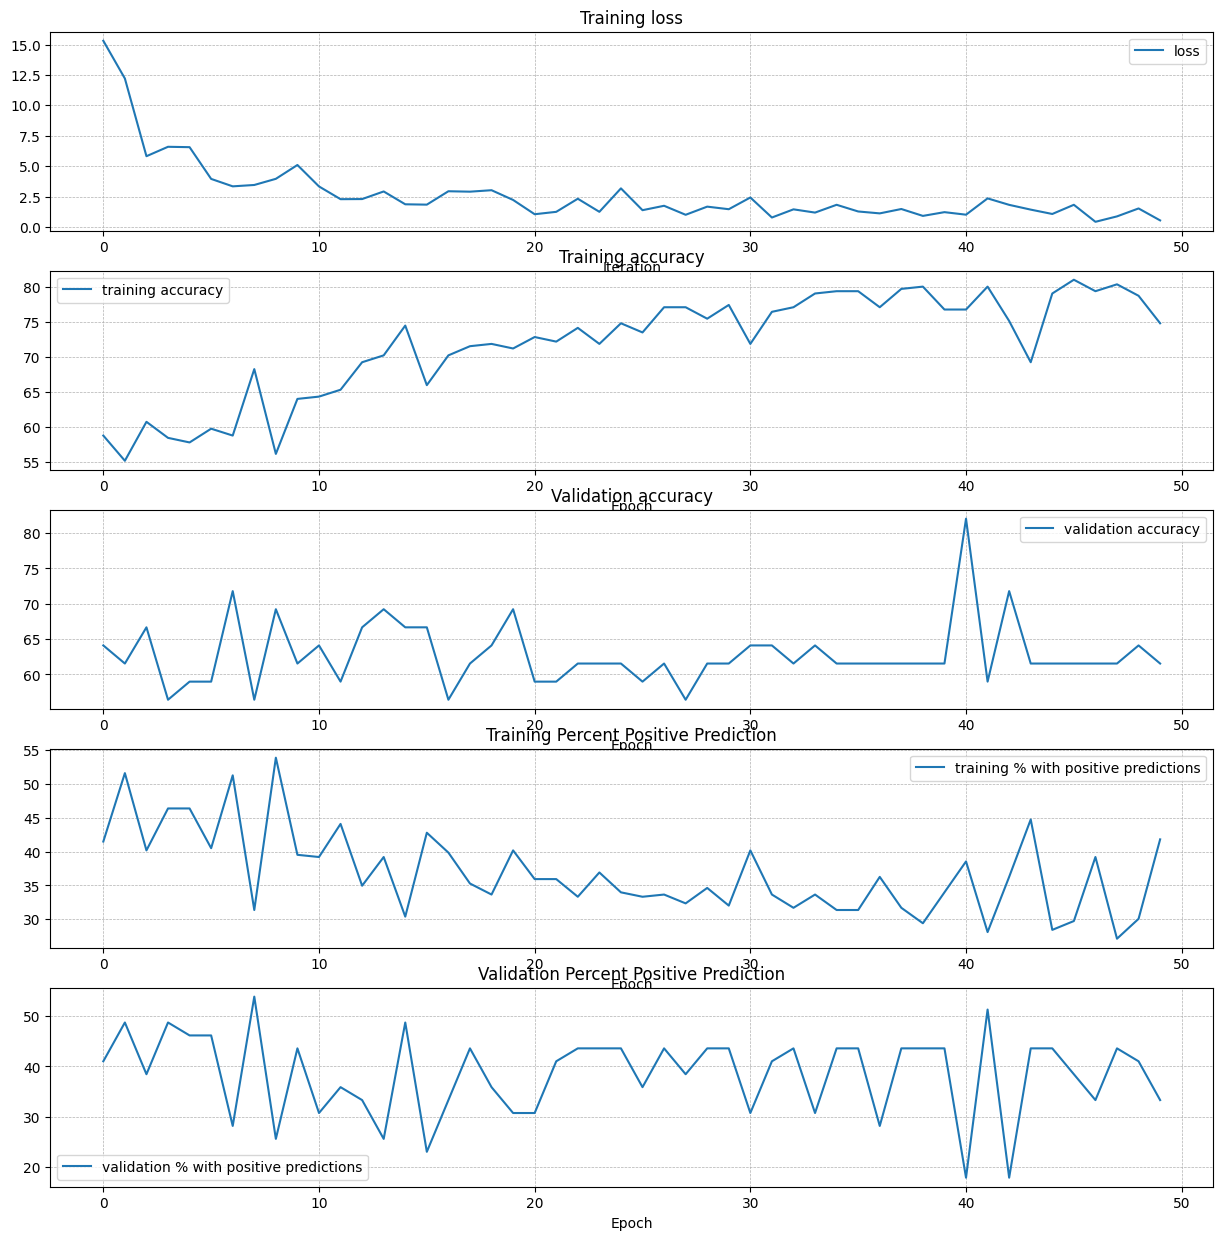

Finished running for lr: 1e-06, hidden size: 100, epochs: 50
Epoch 0, loss = 22.5927, train_acc = 79.0850, val_acc = 61.5385, train_pos = 12.7451, val_pos = 43.5897
Epoch 0, Average Validation F1 Score: 0.4
Epoch 10, loss = 7.8688, train_acc = 61.4379, val_acc = 61.5385, train_pos = 47.3856, val_pos = 38.4615
Epoch 10, Average Validation F1 Score: 0.3478260869565218
Epoch 20, loss = 3.1912, train_acc = 67.6471, val_acc = 64.1026, train_pos = 45.0980, val_pos = 30.7692
Epoch 20, Average Validation F1 Score: 0.3
Epoch 30, loss = 0.6157, train_acc = 73.8562, val_acc = 64.1026, train_pos = 31.6993, val_pos = 35.8974
Epoch 30, Average Validation F1 Score: 0.36363636363636365
Epoch 40, loss = 2.1651, train_acc = 76.1438, val_acc = 56.4103, train_pos = 33.3333, val_pos = 43.5897
Epoch 40, Average Validation F1 Score: 0.31999999999999995
Epoch 50, loss = 0.8099, train_acc = 79.7386, val_acc = 66.6667, train_pos = 35.6209, val_pos = 33.3333
Epoch 50, Average Validation F1 Score: 0.3809523809523

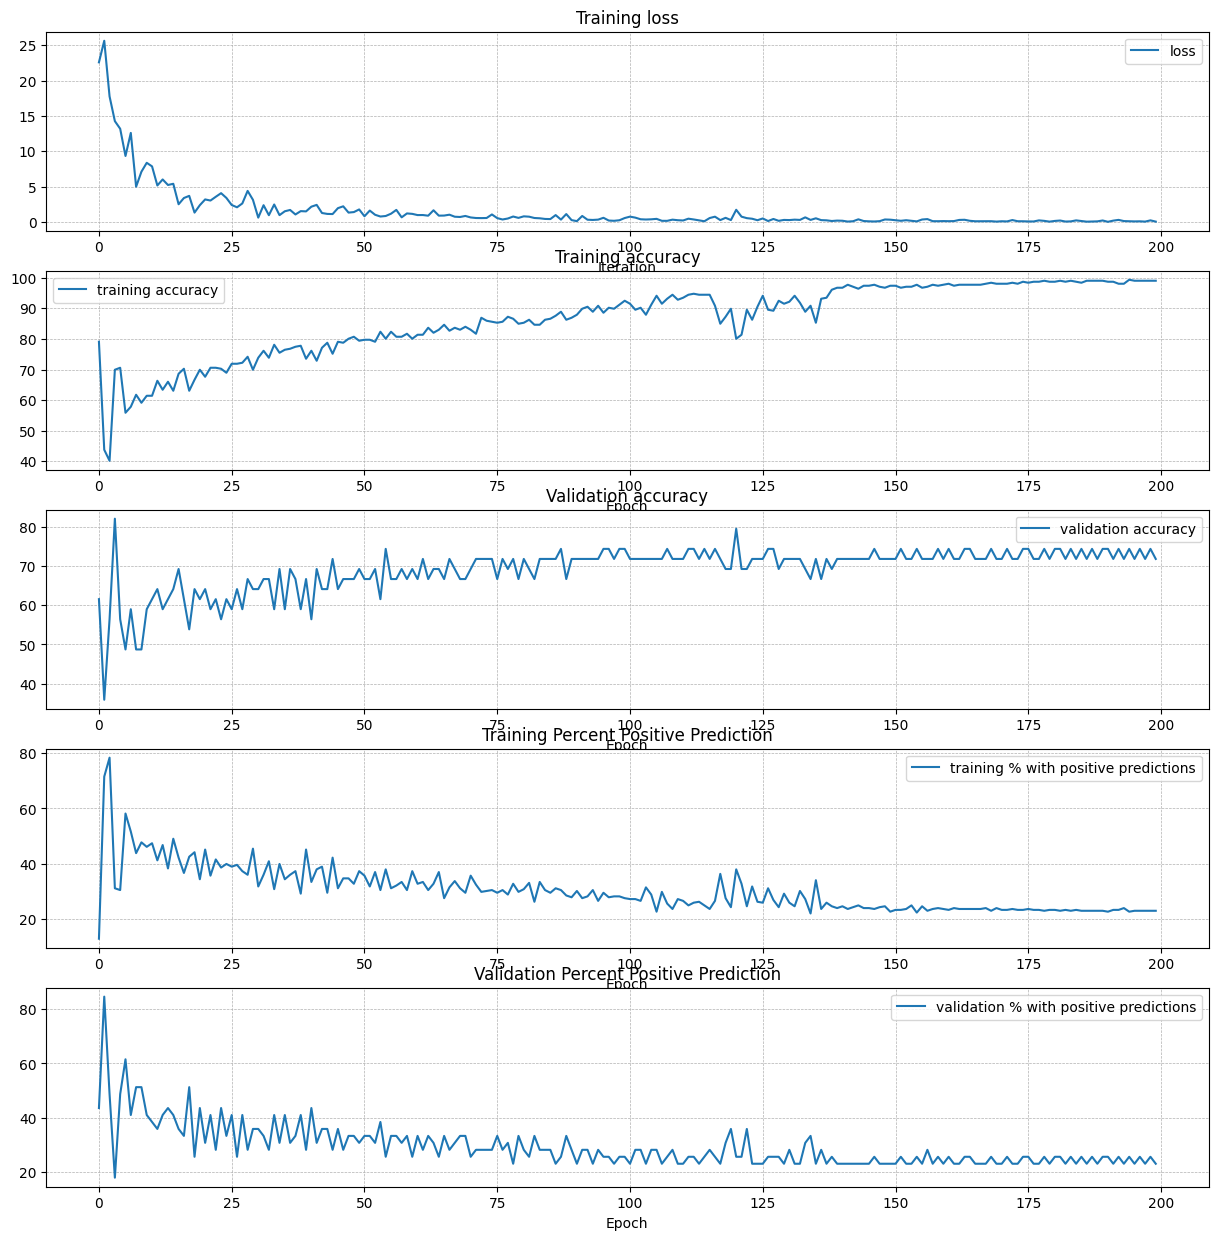

Finished running for lr: 1e-06, hidden size: 100, epochs: 200
Epoch 0, loss = 20.5987, train_acc = 42.1569, val_acc = 82.0513, train_pos = 65.3595, val_pos = 17.9487
Epoch 0, Average Validation F1 Score: 0.5333333333333333
Epoch 10, loss = 4.1689, train_acc = 68.3007, val_acc = 46.1538, train_pos = 40.5229, val_pos = 58.9744
Epoch 10, Average Validation F1 Score: 0.3225806451612903
Epoch 20, loss = 2.7473, train_acc = 65.3595, val_acc = 41.0256, train_pos = 44.1176, val_pos = 64.1026
Epoch 20, Average Validation F1 Score: 0.30303030303030304
Epoch 30, loss = 8.3626, train_acc = 61.1111, val_acc = 79.4872, train_pos = 50.9804, val_pos = 20.5128
Epoch 30, Average Validation F1 Score: 0.5
Epoch 40, loss = 1.1112, train_acc = 82.0261, val_acc = 51.2821, train_pos = 30.0654, val_pos = 53.8462
Epoch 40, Average Validation F1 Score: 0.3448275862068965


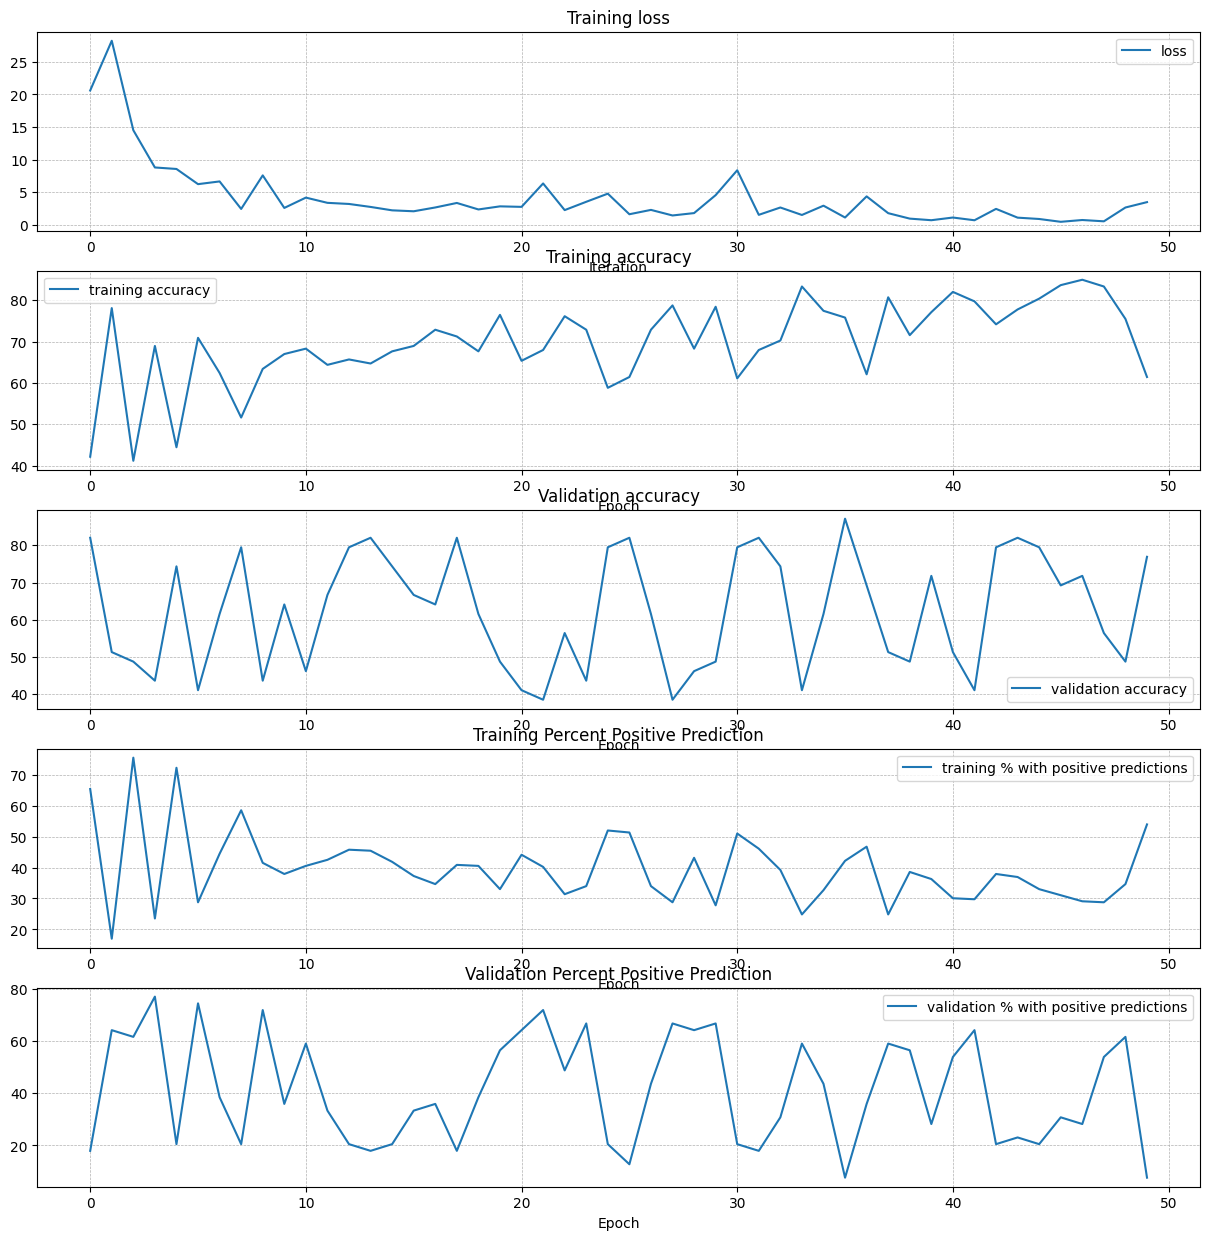

Finished running for lr: 1e-05, hidden size: 100, epochs: 50
Epoch 0, loss = 40.2282, train_acc = 38.2353, val_acc = 76.9231, train_pos = 67.9739, val_pos = 7.6923
Epoch 0, Average Validation F1 Score: 0.18181818181818182
Epoch 10, loss = 4.2032, train_acc = 59.8039, val_acc = 76.9231, train_pos = 50.9804, val_pos = 17.9487
Epoch 10, Average Validation F1 Score: 0.39999999999999997
Epoch 20, loss = 3.2539, train_acc = 72.8758, val_acc = 53.8462, train_pos = 34.6405, val_pos = 56.4103
Epoch 20, Average Validation F1 Score: 0.39999999999999997
Epoch 30, loss = 0.5238, train_acc = 75.8170, val_acc = 76.9231, train_pos = 38.8889, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.3076923076923077
Epoch 40, loss = 1.6582, train_acc = 80.3922, val_acc = 51.2821, train_pos = 29.7386, val_pos = 58.9744
Epoch 40, Average Validation F1 Score: 0.3870967741935483
Epoch 50, loss = 0.5411, train_acc = 86.2745, val_acc = 66.6667, train_pos = 29.7386, val_pos = 33.3333
Epoch 50, Average Valida

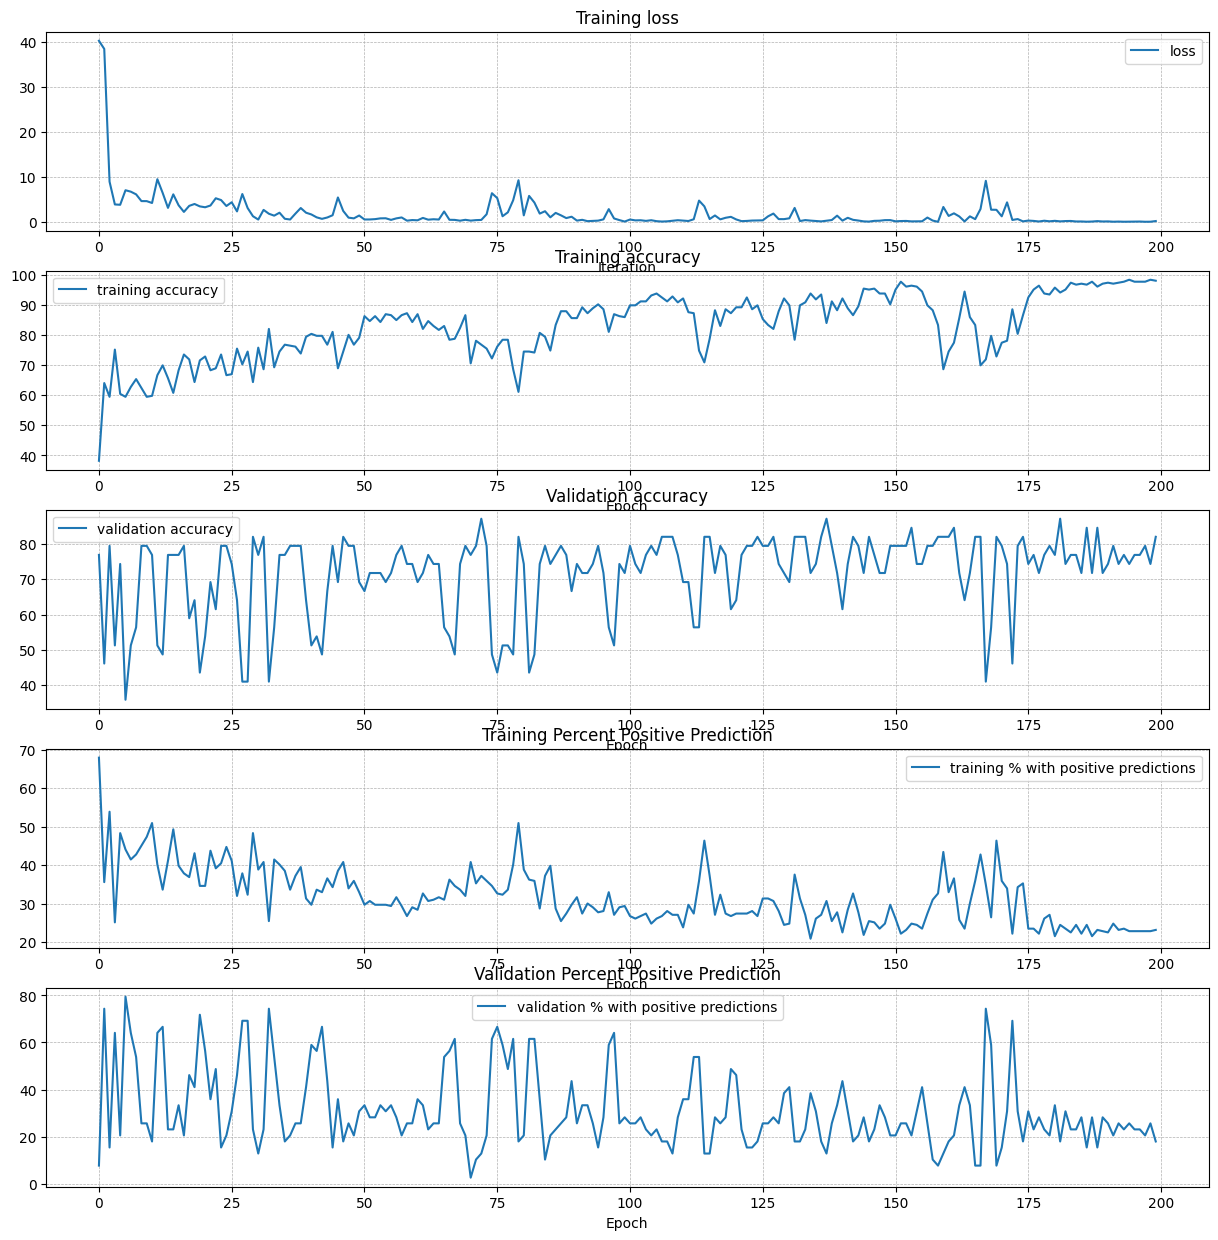

Finished running for lr: 1e-05, hidden size: 100, epochs: 200
Epoch 0, loss = 89.4754, train_acc = 44.1176, val_acc = 79.4872, train_pos = 66.6667, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 24.2439, train_acc = 58.1699, val_acc = 56.4103, train_pos = 49.3464, val_pos = 43.5897
Epoch 10, Average Validation F1 Score: 0.31999999999999995
Epoch 20, loss = 3.7256, train_acc = 71.2418, val_acc = 33.3333, train_pos = 36.9281, val_pos = 71.7949
Epoch 20, Average Validation F1 Score: 0.2777777777777778
Epoch 30, loss = 0.4636, train_acc = 81.3725, val_acc = 82.0513, train_pos = 32.6797, val_pos = 7.6923
Epoch 30, Average Validation F1 Score: 0.36363636363636365
Epoch 40, loss = 2.0233, train_acc = 73.5294, val_acc = 82.0513, train_pos = 39.2157, val_pos = 2.5641
Epoch 40, Average Validation F1 Score: 0.2222222222222222


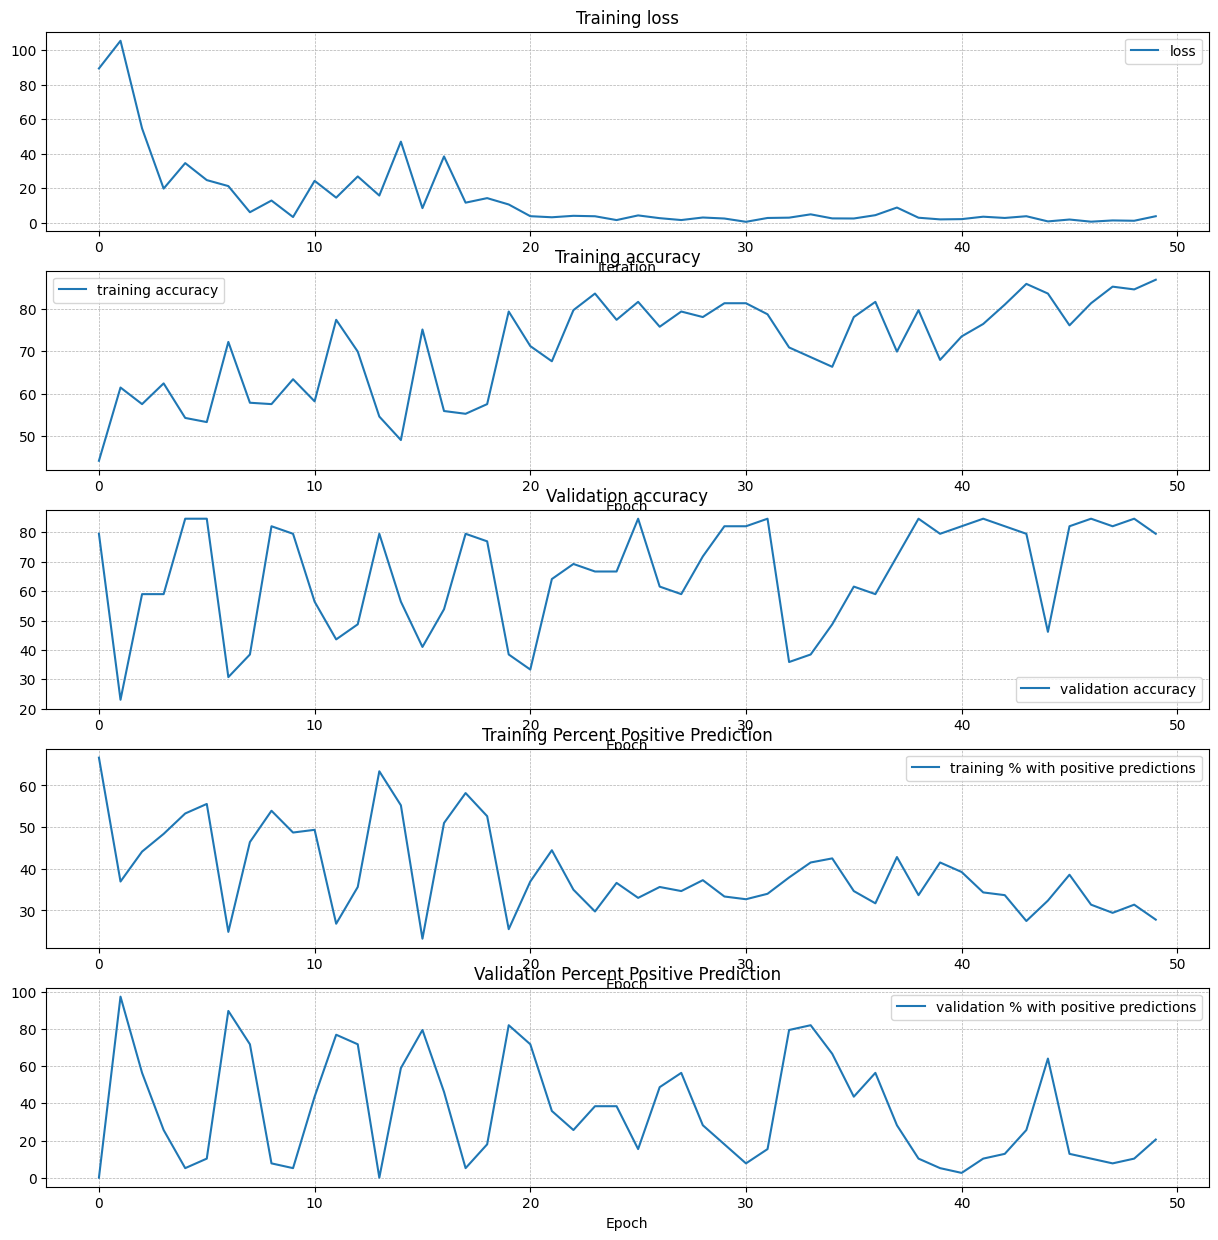

Finished running for lr: 0.0001, hidden size: 100, epochs: 50
Epoch 0, loss = 83.6695, train_acc = 36.6013, val_acc = 79.4872, train_pos = 75.4902, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 5.5073, train_acc = 53.2680, val_acc = 84.6154, train_pos = 62.0915, val_pos = 5.1282
Epoch 10, Average Validation F1 Score: 0.4
Epoch 20, loss = 1.5284, train_acc = 78.7582, val_acc = 82.0513, train_pos = 28.1046, val_pos = 28.2051
Epoch 20, Average Validation F1 Score: 0.631578947368421
Epoch 30, loss = 6.2960, train_acc = 65.3595, val_acc = 58.9744, train_pos = 43.4641, val_pos = 56.4103
Epoch 30, Average Validation F1 Score: 0.4666666666666667
Epoch 40, loss = 1.4562, train_acc = 79.4118, val_acc = 74.3590, train_pos = 32.0261, val_pos = 35.8974
Epoch 40, Average Validation F1 Score: 0.5454545454545454
Epoch 50, loss = 1.0490, train_acc = 83.6601, val_acc = 82.0513, train_pos = 27.1242, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0.4615384615384615


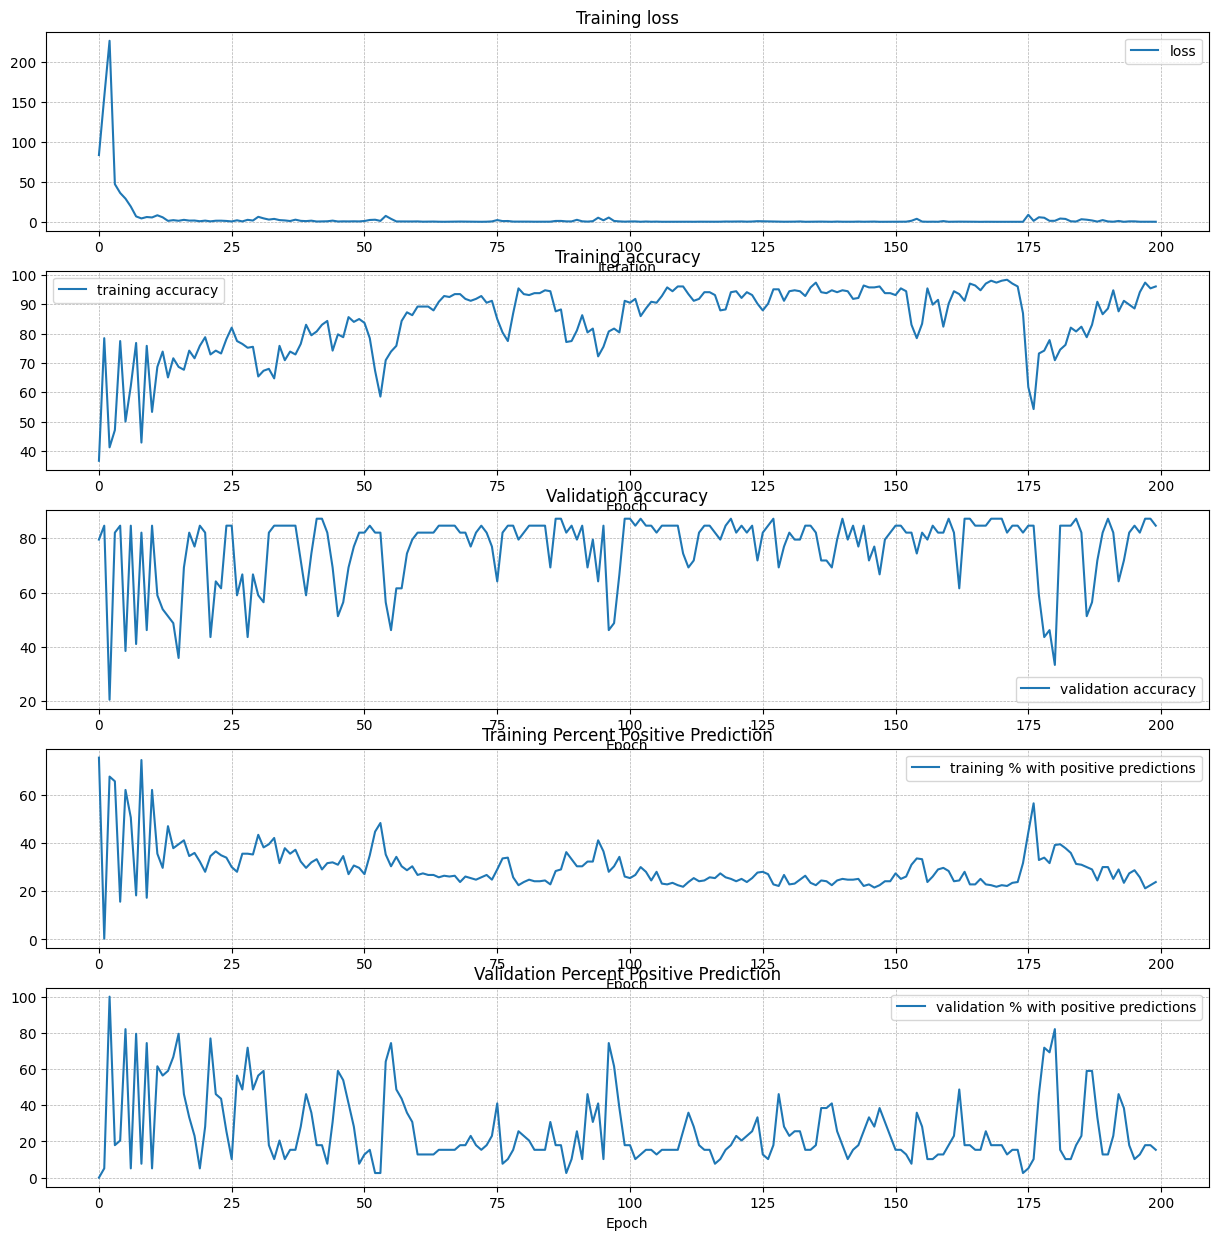

Finished running for lr: 0.0001, hidden size: 100, epochs: 200
Epoch 0, loss = 767.4000, train_acc = 41.8301, val_acc = 84.6154, train_pos = 66.3399, val_pos = 5.1282
Epoch 0, Average Validation F1 Score: 0.4
Epoch 10, loss = 178.7829, train_acc = 60.7843, val_acc = 46.1538, train_pos = 43.4641, val_pos = 74.3590
Epoch 10, Average Validation F1 Score: 0.4324324324324324
Epoch 20, loss = 112.5023, train_acc = 70.5882, val_acc = 35.8974, train_pos = 42.1569, val_pos = 79.4872
Epoch 20, Average Validation F1 Score: 0.358974358974359
Epoch 30, loss = 54.6389, train_acc = 64.7059, val_acc = 41.0256, train_pos = 41.5033, val_pos = 74.3590
Epoch 30, Average Validation F1 Score: 0.3783783783783784
Epoch 40, loss = 268.7747, train_acc = 63.7255, val_acc = 66.6667, train_pos = 48.3660, val_pos = 38.4615
Epoch 40, Average Validation F1 Score: 0.43478260869565216


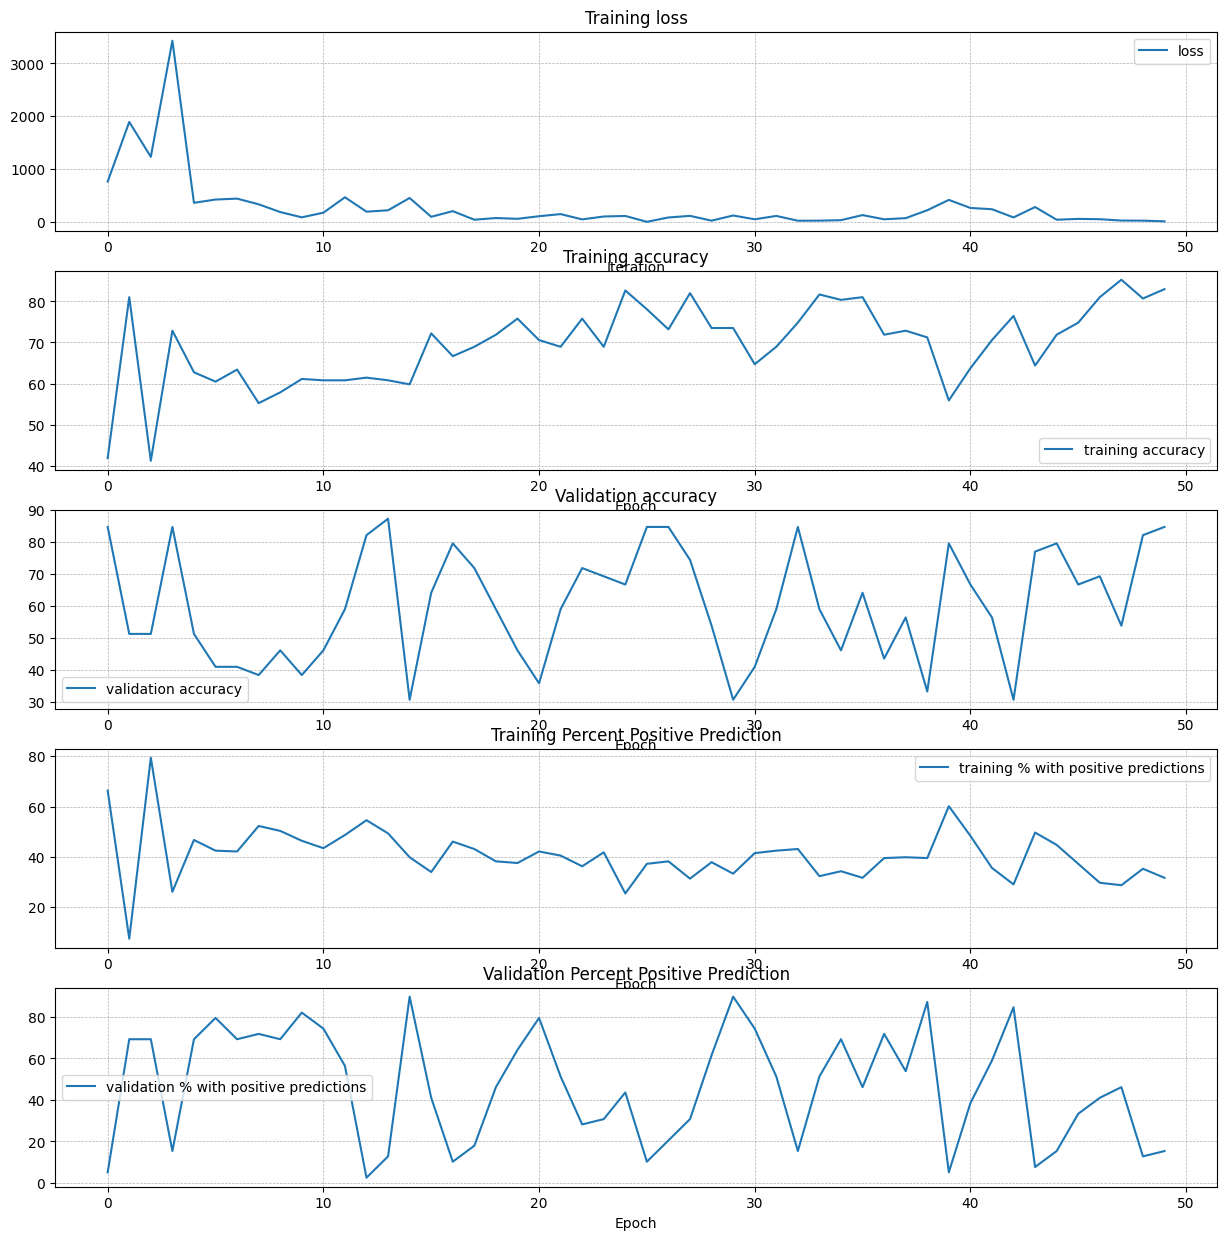

Finished running for lr: 0.001, hidden size: 100, epochs: 50
Epoch 0, loss = 897.9120, train_acc = 30.3922, val_acc = 82.0513, train_pos = 79.0850, val_pos = 2.5641
Epoch 0, Average Validation F1 Score: 0.2222222222222222
Epoch 10, loss = 63.1207, train_acc = 73.8562, val_acc = 66.6667, train_pos = 35.6209, val_pos = 28.2051
Epoch 10, Average Validation F1 Score: 0.3157894736842105
Epoch 20, loss = 12.8989, train_acc = 66.3399, val_acc = 84.6154, train_pos = 45.7516, val_pos = 5.1282
Epoch 20, Average Validation F1 Score: 0.4
Epoch 30, loss = 54.5230, train_acc = 68.6275, val_acc = 28.2051, train_pos = 40.8497, val_pos = 92.3077
Epoch 30, Average Validation F1 Score: 0.3636363636363636
Epoch 40, loss = 12.8112, train_acc = 74.1830, val_acc = 82.0513, train_pos = 40.5229, val_pos = 7.6923
Epoch 40, Average Validation F1 Score: 0.36363636363636365
Epoch 50, loss = 2.4109, train_acc = 80.7190, val_acc = 84.6154, train_pos = 33.9869, val_pos = 15.3846
Epoch 50, Average Validation F1 Score:

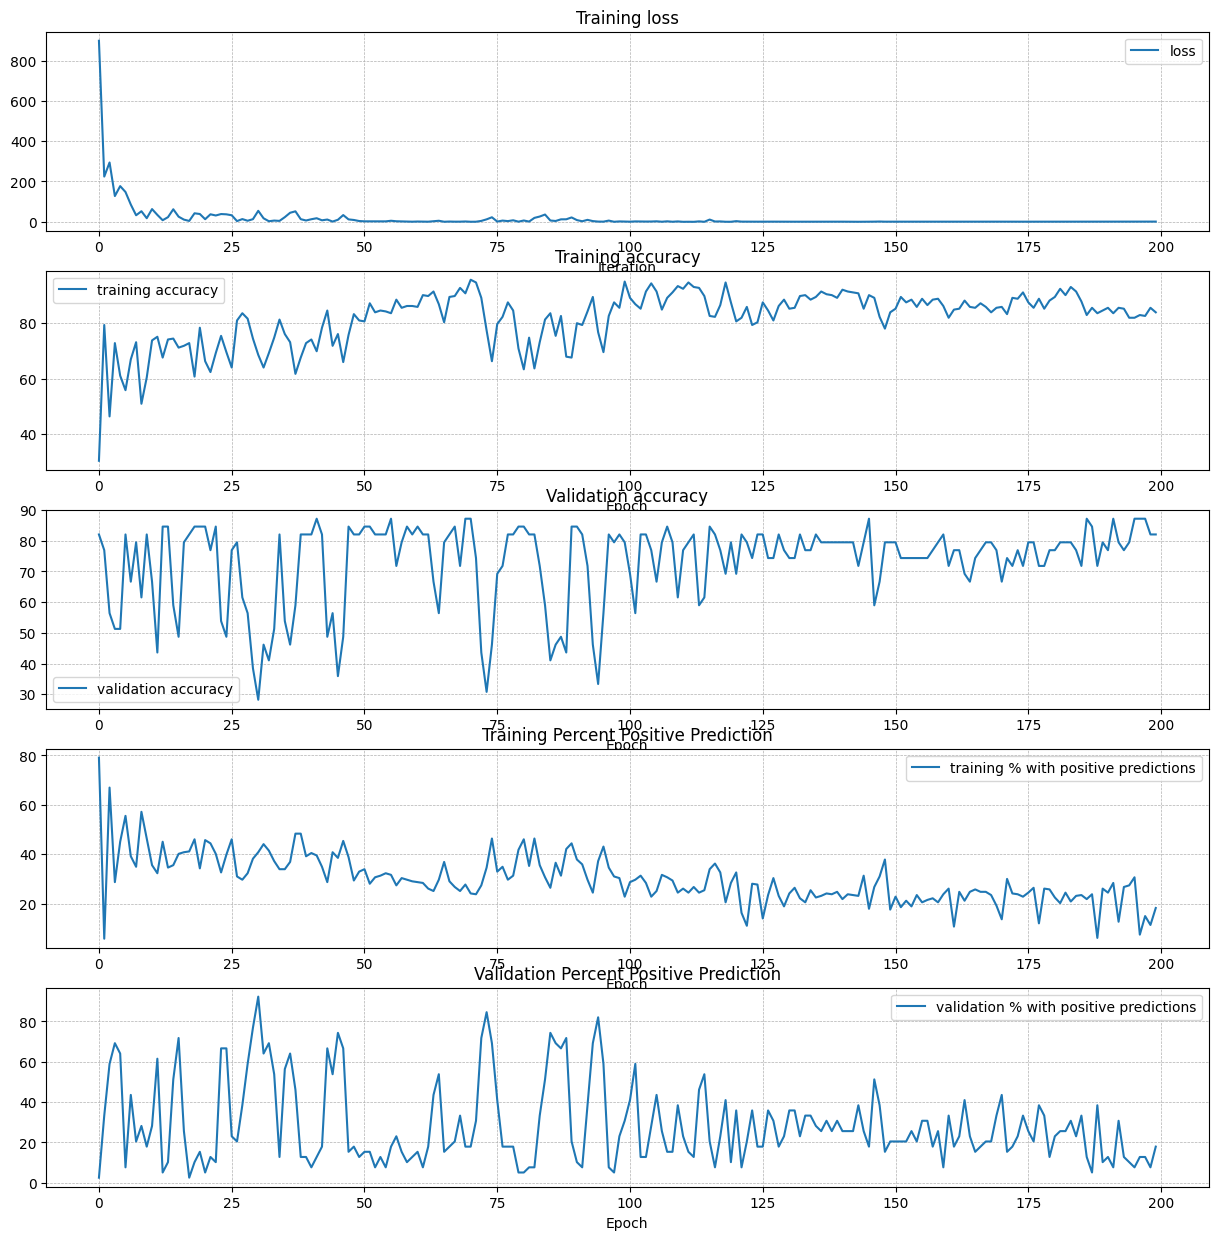

Finished running for lr: 0.001, hidden size: 100, epochs: 200
Epoch 0, loss = 31864.9043, train_acc = 55.5556, val_acc = 38.4615, train_pos = 46.0784, val_pos = 82.0513
Epoch 0, Average Validation F1 Score: 0.4
Epoch 10, loss = 1534.1814, train_acc = 79.7386, val_acc = 84.6154, train_pos = 17.9739, val_pos = 10.2564
Epoch 10, Average Validation F1 Score: 0.5
Epoch 20, loss = 1.3283, train_acc = 78.1046, val_acc = 84.6154, train_pos = 19.6078, val_pos = 15.3846
Epoch 20, Average Validation F1 Score: 0.5714285714285715
Epoch 30, loss = 5.9718, train_acc = 80.3922, val_acc = 82.0513, train_pos = 5.5556, val_pos = 7.6923
Epoch 30, Average Validation F1 Score: 0.36363636363636365
Epoch 40, loss = 1.2193, train_acc = 81.6993, val_acc = 84.6154, train_pos = 6.8627, val_pos = 5.1282
Epoch 40, Average Validation F1 Score: 0.4


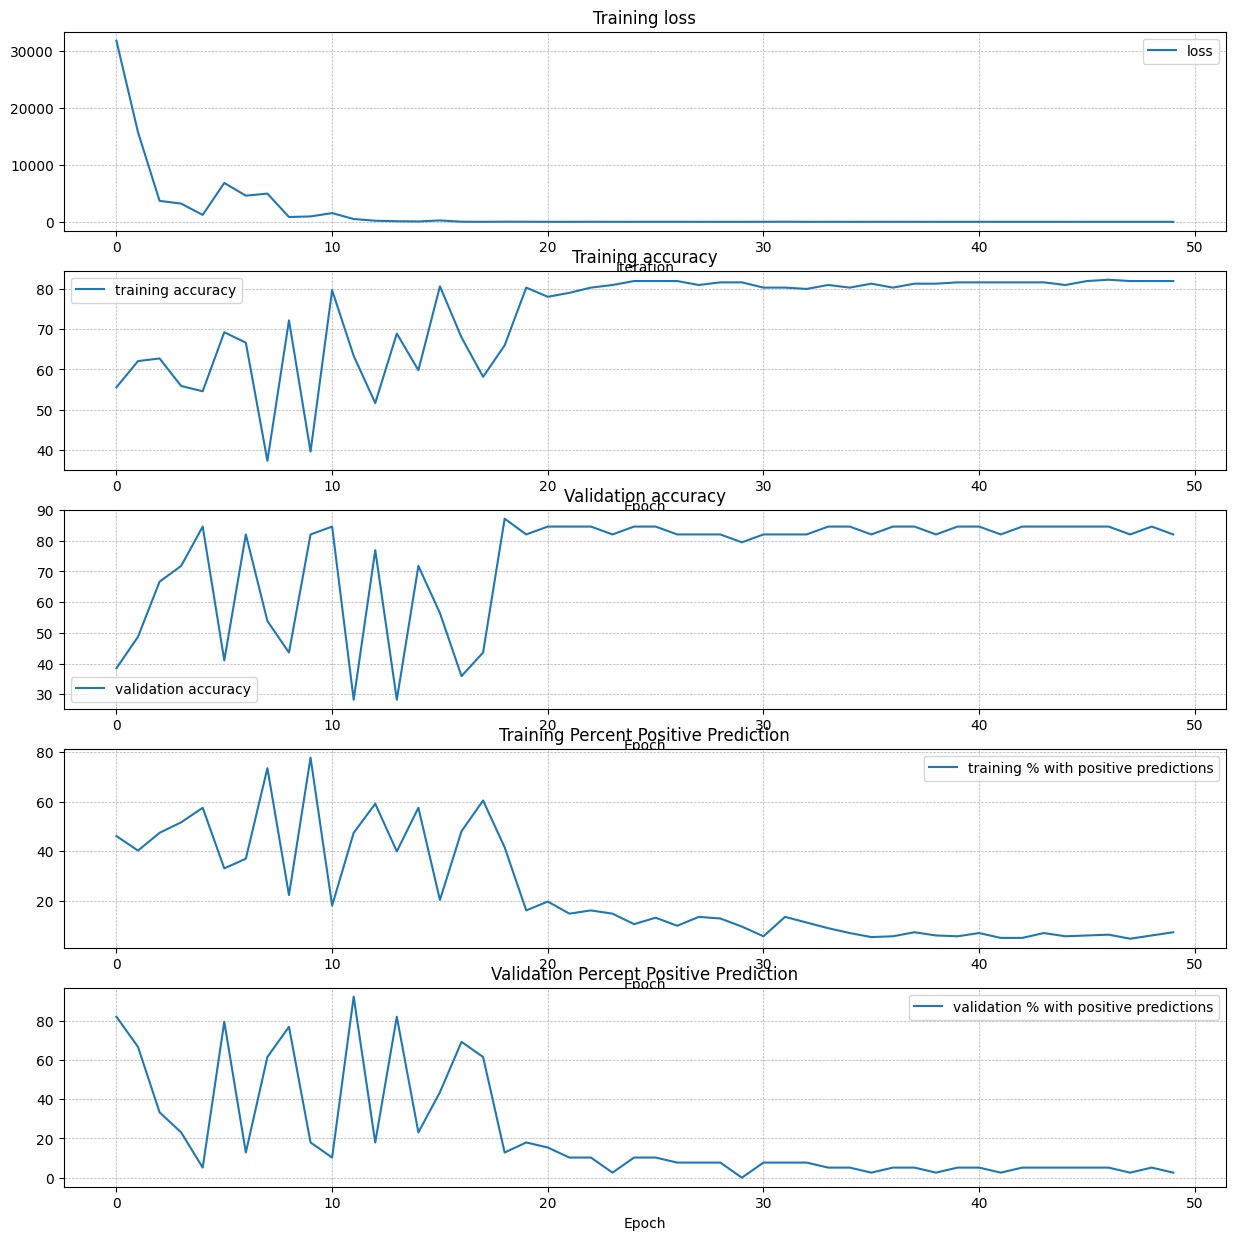

Finished running for lr: 0.01, hidden size: 100, epochs: 50
Epoch 0, loss = 18549.4512, train_acc = 58.1699, val_acc = 20.5128, train_pos = 36.9281, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 1.0084, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 10, Average Validation F1 Score: 0.0
Epoch 20, loss = 1.0851, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 20, Average Validation F1 Score: 0.0
Epoch 30, loss = 0.9838, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 30, Average Validation F1 Score: 0.0
Epoch 40, loss = 1.0482, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 40, Average Validation F1 Score: 0.0
Epoch 50, loss = 1.0107, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 50, Average Validation F1 Score: 0.0
Epoch 60, loss = 0.9739, train_acc = 78.7582, val_

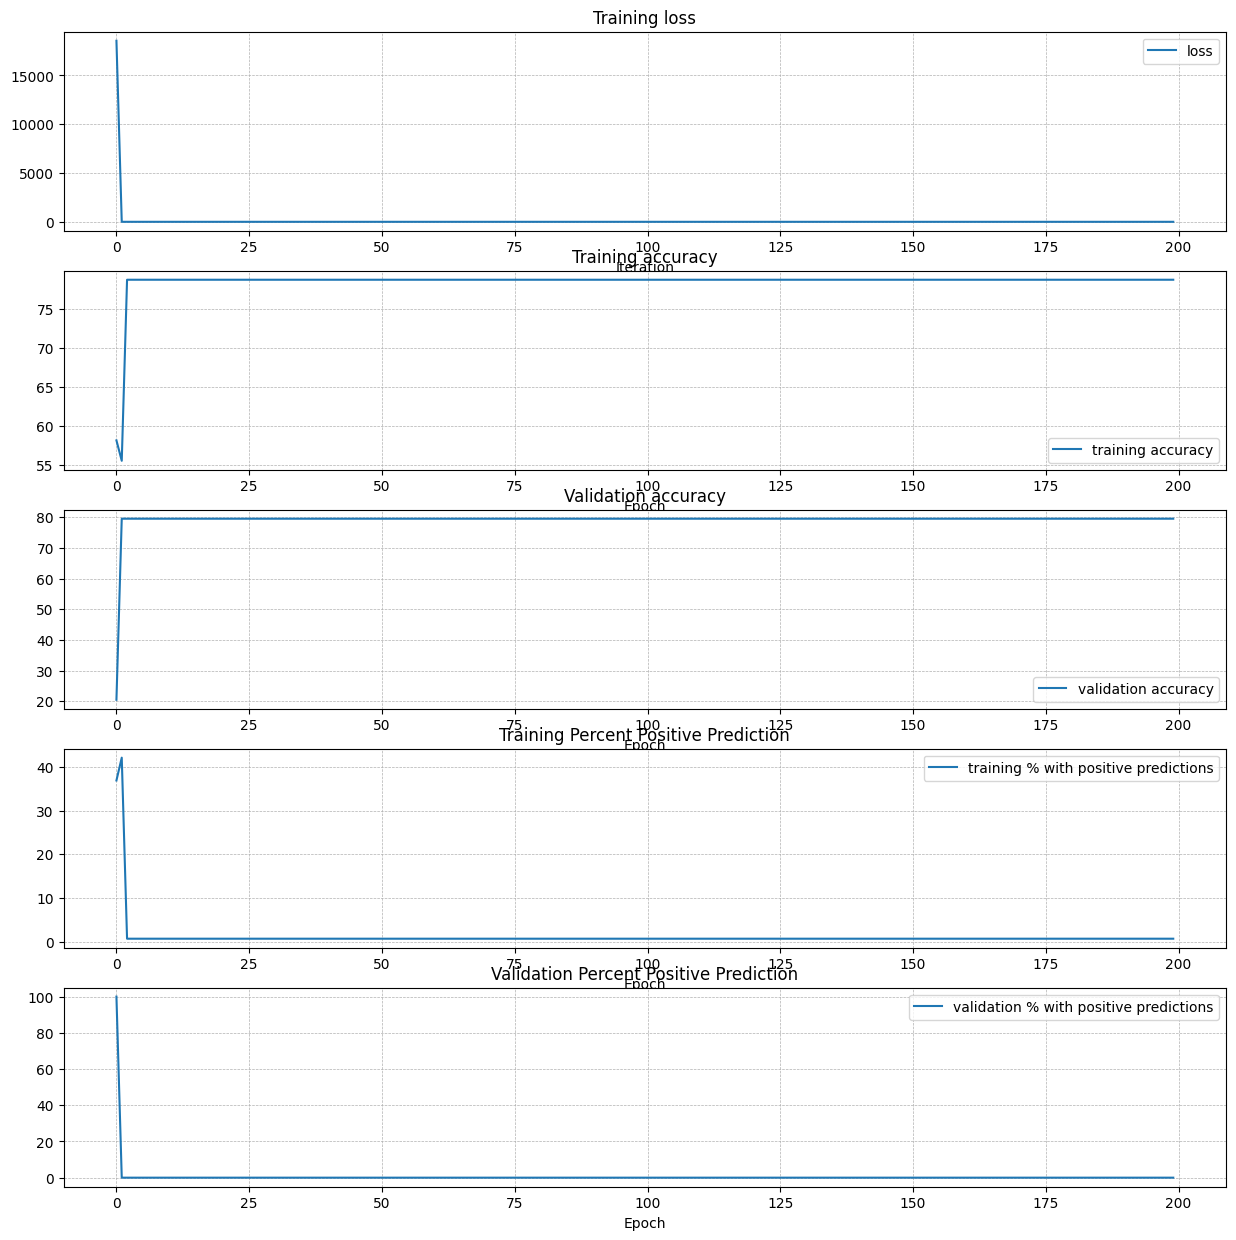

Finished running for lr: 0.01, hidden size: 100, epochs: 200
Epoch 0, loss = 25.7080, train_acc = 50.6536, val_acc = 51.2821, train_pos = 41.1765, val_pos = 64.1026
Epoch 0, Average Validation F1 Score: 0.42424242424242425
Epoch 10, loss = 3.4429, train_acc = 71.2418, val_acc = 56.4103, train_pos = 33.0065, val_pos = 48.7179
Epoch 10, Average Validation F1 Score: 0.37037037037037035
Epoch 20, loss = 3.5050, train_acc = 78.4314, val_acc = 30.7692, train_pos = 27.7778, val_pos = 84.6154
Epoch 20, Average Validation F1 Score: 0.3414634146341463
Epoch 30, loss = 0.5105, train_acc = 90.1961, val_acc = 79.4872, train_pos = 23.2026, val_pos = 25.6410
Epoch 30, Average Validation F1 Score: 0.5555555555555556
Epoch 40, loss = 0.1927, train_acc = 97.3856, val_acc = 82.0513, train_pos = 23.2026, val_pos = 23.0769
Epoch 40, Average Validation F1 Score: 0.5882352941176471


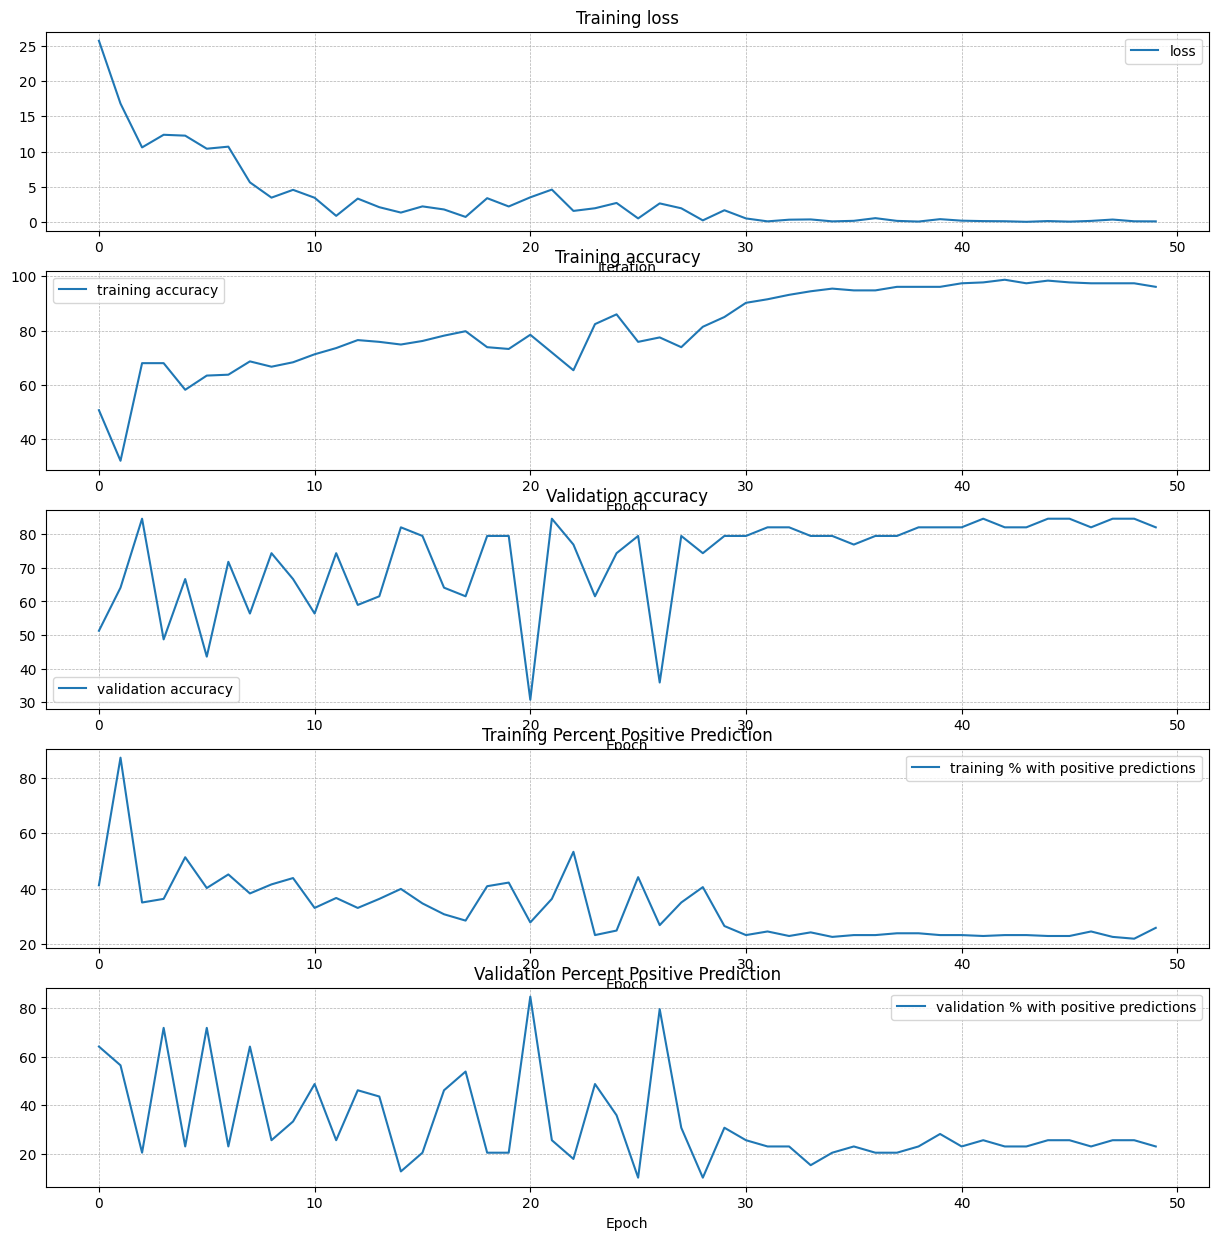

Finished running for lr: 1e-06, hidden size: 1000, epochs: 50
Epoch 0, loss = 10.6677, train_acc = 41.1765, val_acc = 69.2308, train_pos = 64.3791, val_pos = 25.6410
Epoch 0, Average Validation F1 Score: 0.33333333333333326
Epoch 10, loss = 2.2059, train_acc = 75.1634, val_acc = 74.3590, train_pos = 38.8889, val_pos = 20.5128
Epoch 10, Average Validation F1 Score: 0.375
Epoch 20, loss = 1.4411, train_acc = 78.4314, val_acc = 61.5385, train_pos = 34.9673, val_pos = 43.5897
Epoch 20, Average Validation F1 Score: 0.4
Epoch 30, loss = 0.4026, train_acc = 84.9673, val_acc = 74.3590, train_pos = 31.6993, val_pos = 20.5128
Epoch 30, Average Validation F1 Score: 0.375
Epoch 40, loss = 0.5050, train_acc = 93.7908, val_acc = 56.4103, train_pos = 19.6078, val_pos = 58.9744
Epoch 40, Average Validation F1 Score: 0.4516129032258065
Epoch 50, loss = 0.0528, train_acc = 96.4052, val_acc = 82.0513, train_pos = 25.4902, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0.4615384615384615
Epoch 6

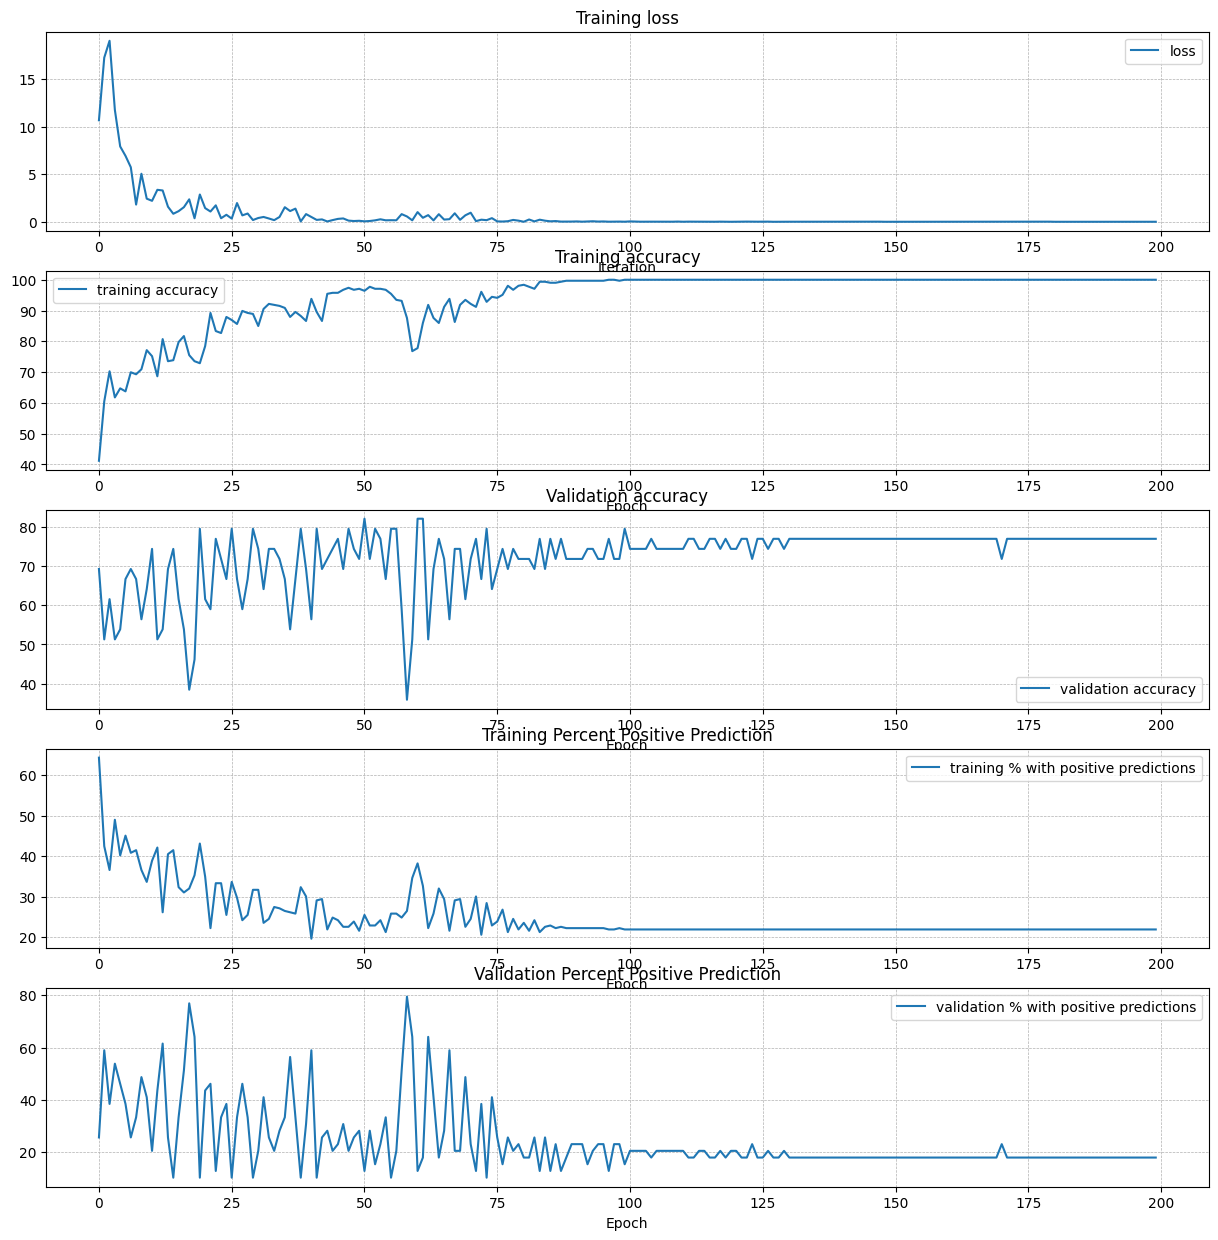

Finished running for lr: 1e-06, hidden size: 1000, epochs: 200
Epoch 0, loss = 50.5256, train_acc = 67.6471, val_acc = 20.5128, train_pos = 29.4118, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 20.8301, train_acc = 62.0915, val_acc = 56.4103, train_pos = 44.7712, val_pos = 43.5897
Epoch 10, Average Validation F1 Score: 0.31999999999999995
Epoch 20, loss = 22.4674, train_acc = 64.3791, val_acc = 46.1538, train_pos = 41.1765, val_pos = 69.2308
Epoch 20, Average Validation F1 Score: 0.39999999999999997
Epoch 30, loss = 1.9498, train_acc = 82.6797, val_acc = 79.4872, train_pos = 33.3333, val_pos = 25.6410
Epoch 30, Average Validation F1 Score: 0.5555555555555556
Epoch 40, loss = 2.1910, train_acc = 85.2941, val_acc = 84.6154, train_pos = 30.0654, val_pos = 20.5128
Epoch 40, Average Validation F1 Score: 0.625


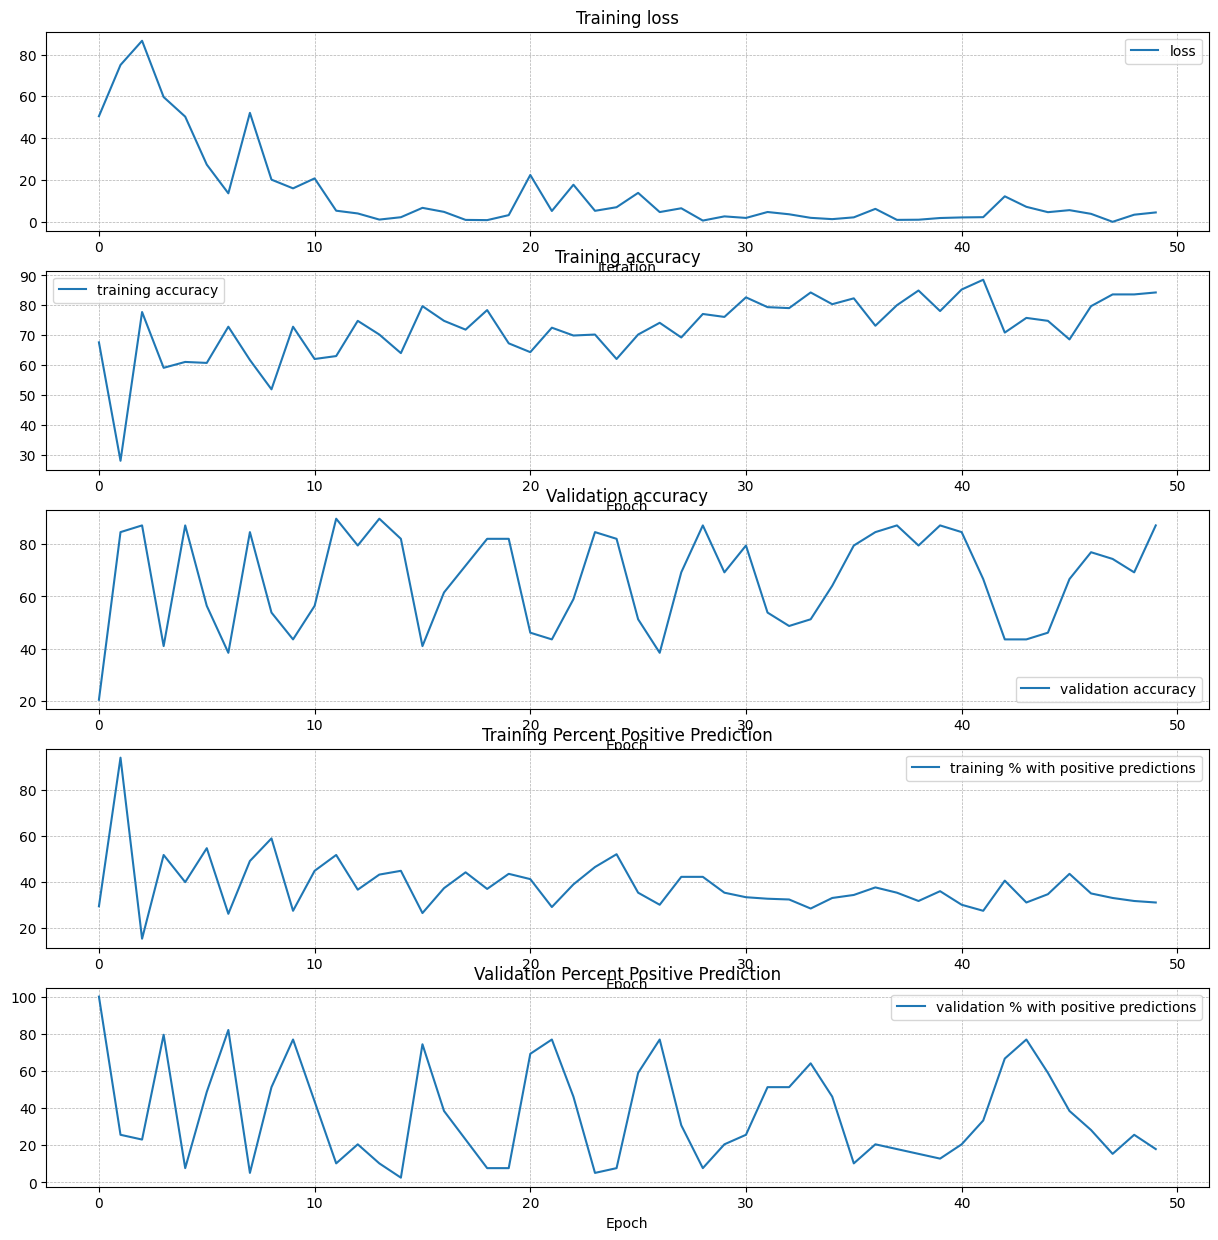

Finished running for lr: 1e-05, hidden size: 1000, epochs: 50
Epoch 0, loss = 80.3068, train_acc = 37.9085, val_acc = 82.0513, train_pos = 73.5294, val_pos = 17.9487
Epoch 0, Average Validation F1 Score: 0.5333333333333333
Epoch 10, loss = 22.5350, train_acc = 63.0719, val_acc = 76.9231, train_pos = 43.7908, val_pos = 28.2051
Epoch 10, Average Validation F1 Score: 0.5263157894736842
Epoch 20, loss = 5.7733, train_acc = 74.5098, val_acc = 38.4615, train_pos = 34.3137, val_pos = 76.9231
Epoch 20, Average Validation F1 Score: 0.3684210526315789
Epoch 30, loss = 1.6246, train_acc = 83.6601, val_acc = 71.7949, train_pos = 33.0065, val_pos = 23.0769
Epoch 30, Average Validation F1 Score: 0.35294117647058826
Epoch 40, loss = 0.5004, train_acc = 90.1961, val_acc = 71.7949, train_pos = 26.4706, val_pos = 38.4615
Epoch 40, Average Validation F1 Score: 0.5217391304347827
Epoch 50, loss = 4.6570, train_acc = 80.0654, val_acc = 66.6667, train_pos = 32.0261, val_pos = 33.3333
Epoch 50, Average Valid

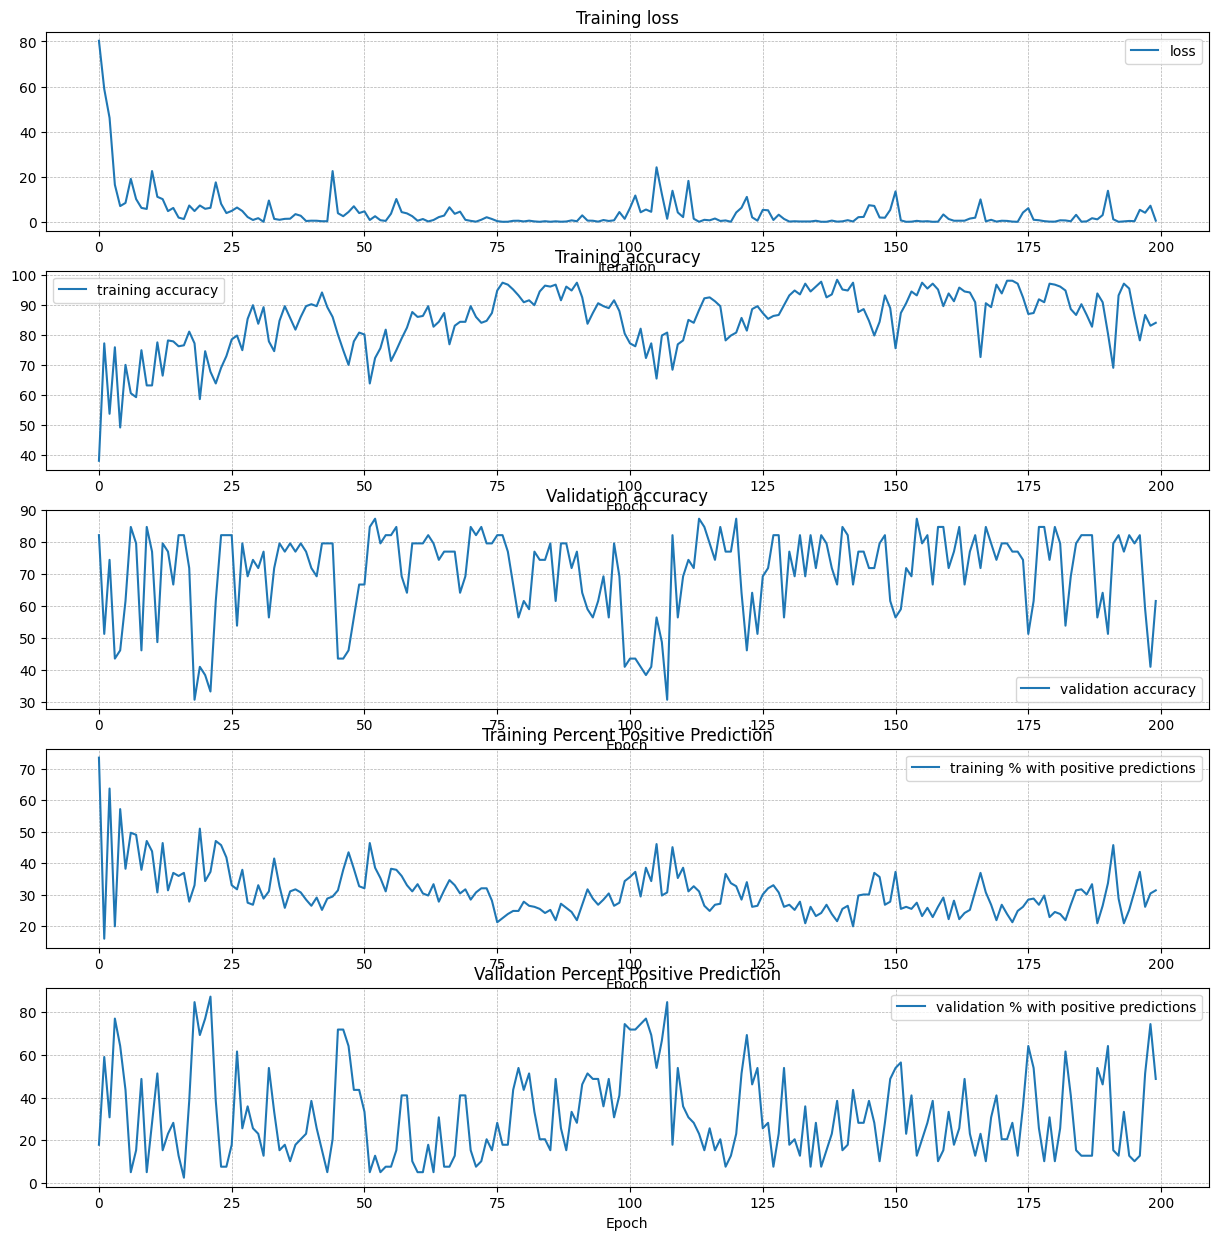

Finished running for lr: 1e-05, hidden size: 1000, epochs: 200
Epoch 0, loss = 105.8007, train_acc = 37.9085, val_acc = 84.6154, train_pos = 71.5686, val_pos = 5.1282
Epoch 0, Average Validation F1 Score: 0.4
Epoch 10, loss = 23.6903, train_acc = 48.3660, val_acc = 84.6154, train_pos = 66.3399, val_pos = 10.2564
Epoch 10, Average Validation F1 Score: 0.5
Epoch 20, loss = 24.5162, train_acc = 68.3007, val_acc = 79.4872, train_pos = 46.4052, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.3333333333333333
Epoch 30, loss = 132.7557, train_acc = 75.4902, val_acc = 84.6154, train_pos = 36.6013, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 27.0868, train_acc = 81.3725, val_acc = 84.6154, train_pos = 33.9869, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715


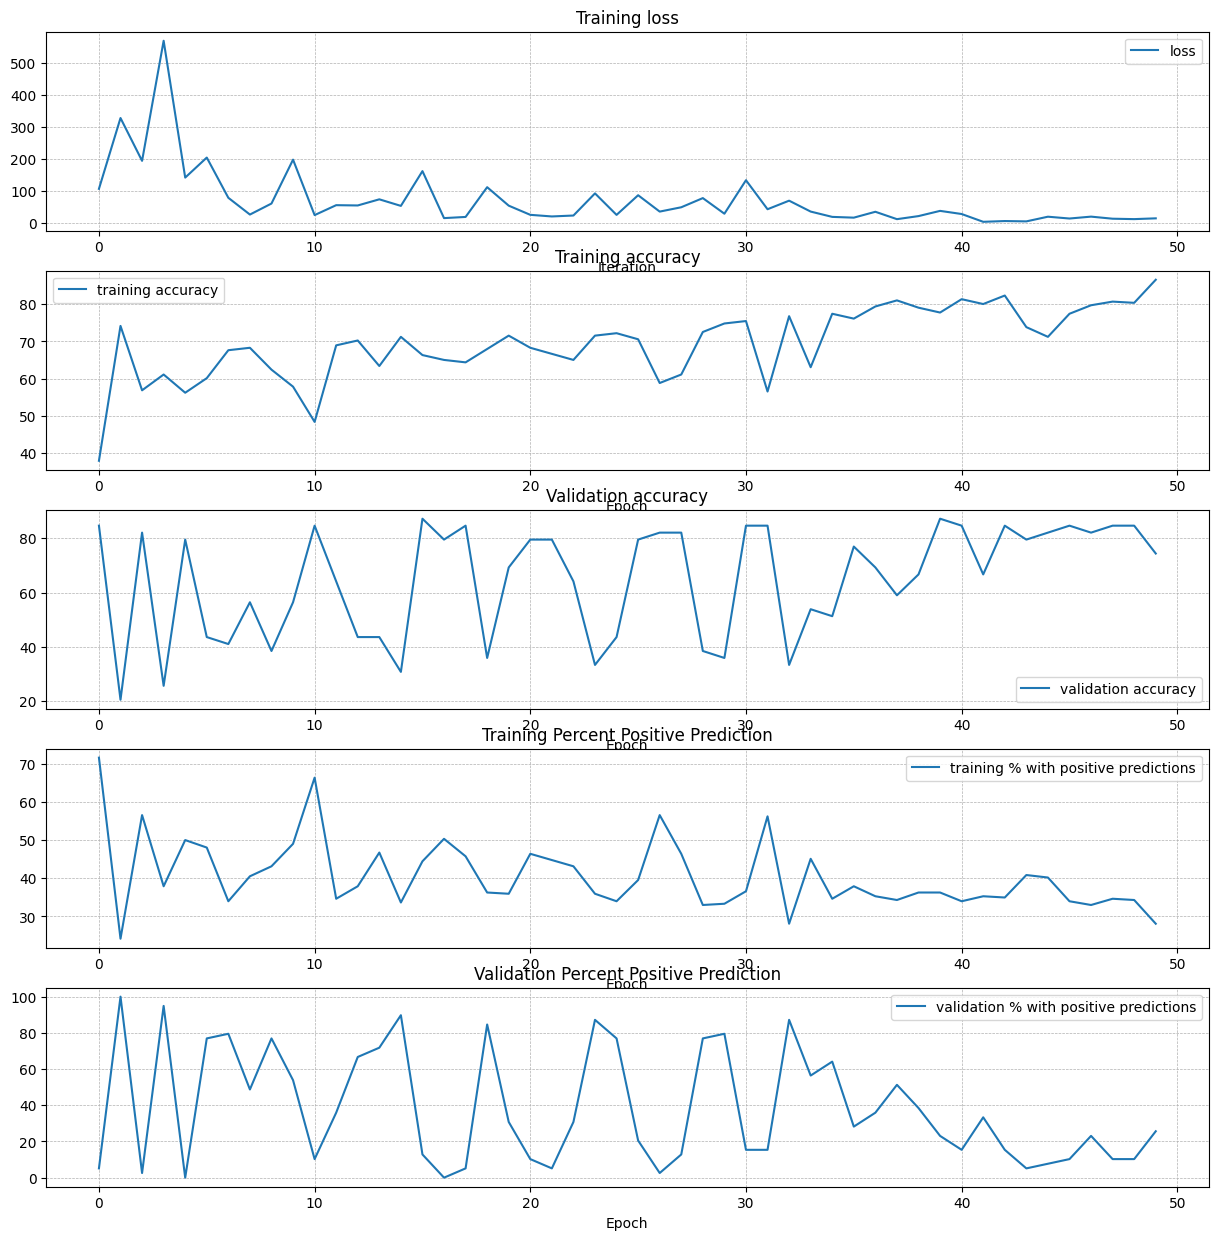

Finished running for lr: 0.0001, hidden size: 1000, epochs: 50
Epoch 0, loss = 2197.7834, train_acc = 46.4052, val_acc = 79.4872, train_pos = 56.5359, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 46.7532, train_acc = 65.6863, val_acc = 61.5385, train_pos = 45.0980, val_pos = 43.5897
Epoch 10, Average Validation F1 Score: 0.4
Epoch 20, loss = 8.1224, train_acc = 67.9739, val_acc = 38.4615, train_pos = 38.8889, val_pos = 82.0513
Epoch 20, Average Validation F1 Score: 0.4
Epoch 30, loss = 11.9380, train_acc = 78.1046, val_acc = 79.4872, train_pos = 33.9869, val_pos = 25.6410
Epoch 30, Average Validation F1 Score: 0.5555555555555556
Epoch 40, loss = 19.1469, train_acc = 66.9935, val_acc = 87.1795, train_pos = 42.4837, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.6153846153846154
Epoch 50, loss = 135.3943, train_acc = 77.4510, val_acc = 35.8974, train_pos = 28.1046, val_pos = 84.6154
Epoch 50, Average Validation F1 Score: 0.3902439024390244
Epoch

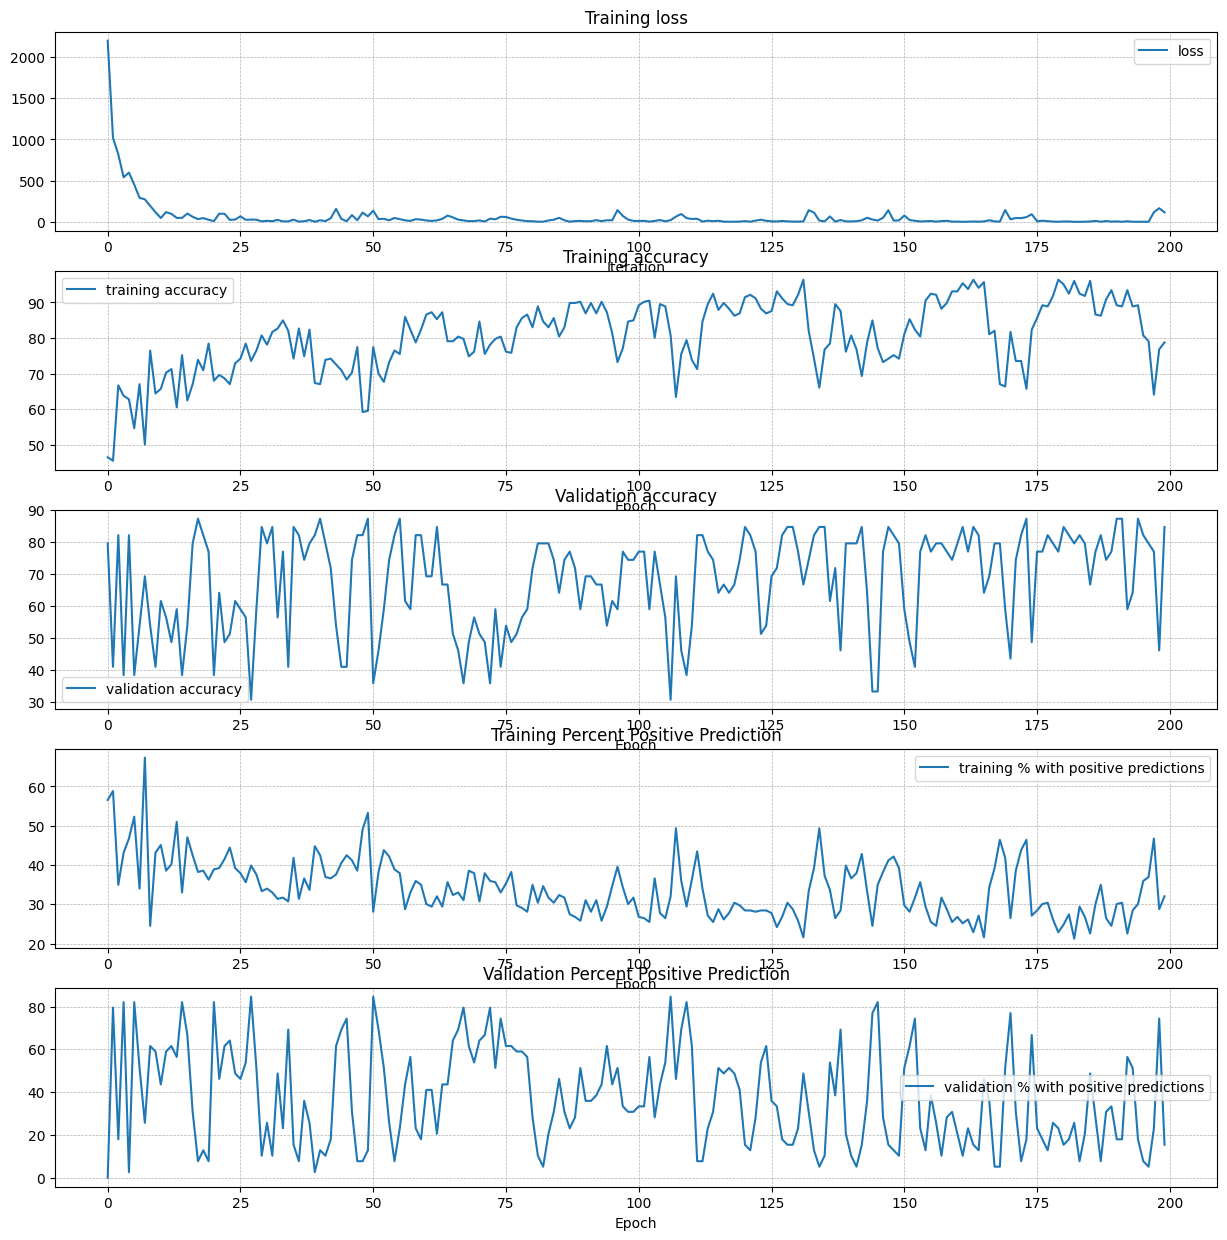

Finished running for lr: 0.0001, hidden size: 1000, epochs: 200
Epoch 0, loss = 2029.6906, train_acc = 57.1895, val_acc = 20.5128, train_pos = 37.2549, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 13.5580, train_acc = 77.4510, val_acc = 79.4872, train_pos = 33.3333, val_pos = 0.0000
Epoch 10, Average Validation F1 Score: 0.0
Epoch 20, loss = 12.5653, train_acc = 74.8366, val_acc = 51.2821, train_pos = 39.8693, val_pos = 64.1026
Epoch 20, Average Validation F1 Score: 0.42424242424242425
Epoch 30, loss = 26.7057, train_acc = 67.9739, val_acc = 76.9231, train_pos = 42.1569, val_pos = 23.0769
Epoch 30, Average Validation F1 Score: 0.47058823529411764
Epoch 40, loss = 15.2195, train_acc = 74.8366, val_acc = 35.8974, train_pos = 30.0654, val_pos = 84.6154
Epoch 40, Average Validation F1 Score: 0.3902439024390244


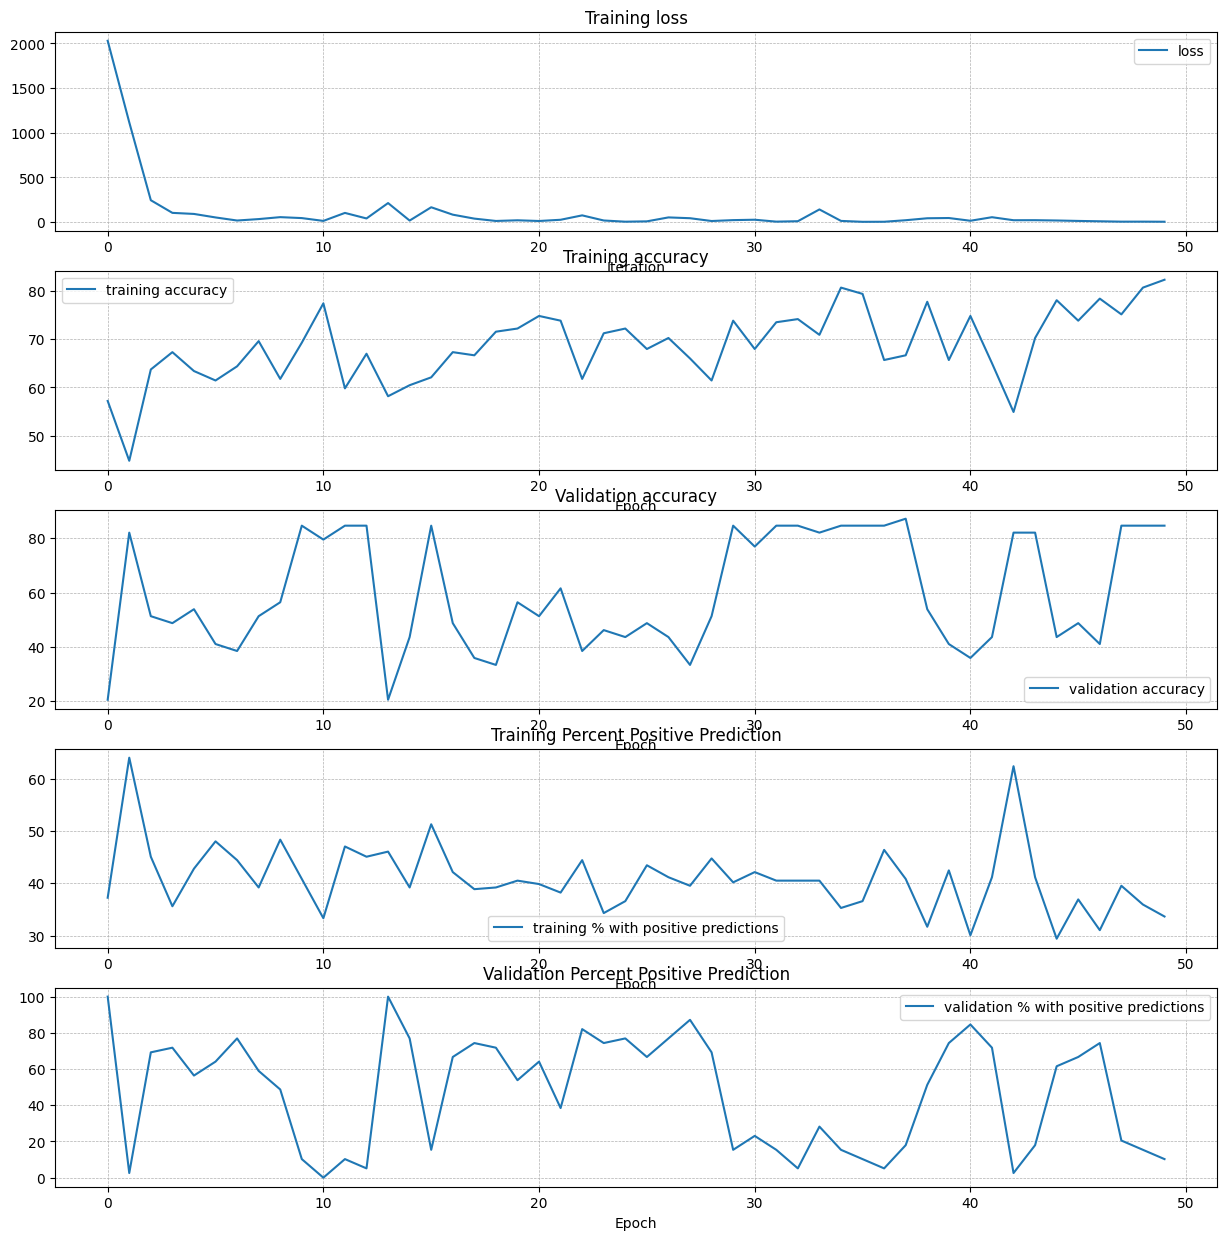

Finished running for lr: 0.001, hidden size: 1000, epochs: 50
Epoch 0, loss = 16032.8311, train_acc = 45.0980, val_acc = 82.0513, train_pos = 57.8431, val_pos = 2.5641
Epoch 0, Average Validation F1 Score: 0.2222222222222222
Epoch 10, loss = 327.6775, train_acc = 78.4314, val_acc = 48.7179, train_pos = 31.6993, val_pos = 61.5385
Epoch 10, Average Validation F1 Score: 0.375
Epoch 20, loss = 178.5447, train_acc = 66.0131, val_acc = 46.1538, train_pos = 44.1176, val_pos = 74.3590
Epoch 20, Average Validation F1 Score: 0.4324324324324324
Epoch 30, loss = 67.9049, train_acc = 70.5882, val_acc = 61.5385, train_pos = 40.8497, val_pos = 43.5897
Epoch 30, Average Validation F1 Score: 0.4
Epoch 40, loss = 48.5643, train_acc = 81.6993, val_acc = 79.4872, train_pos = 33.6601, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.42857142857142855
Epoch 50, loss = 274.6709, train_acc = 63.0719, val_acc = 87.1795, train_pos = 46.4052, val_pos = 17.9487
Epoch 50, Average Validation F1 Score: 0.6

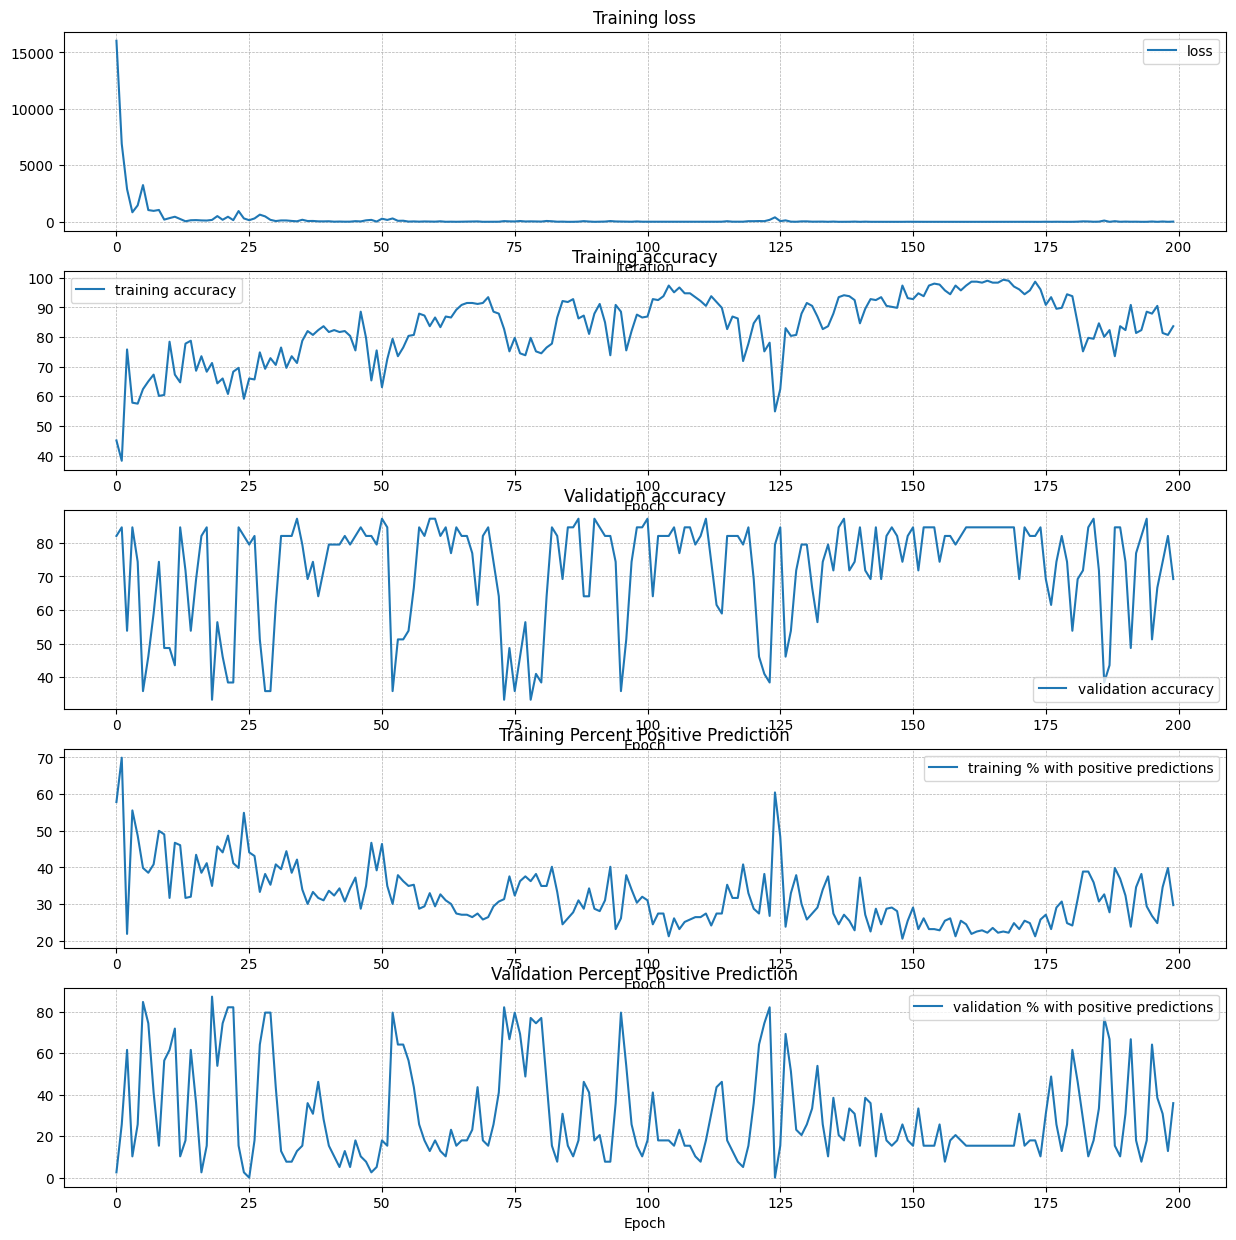

Finished running for lr: 0.001, hidden size: 1000, epochs: 200
Epoch 0, loss = 57968.5625, train_acc = 57.1895, val_acc = 82.0513, train_pos = 43.1373, val_pos = 17.9487
Epoch 0, Average Validation F1 Score: 0.5333333333333333
Epoch 10, loss = 74.5632, train_acc = 80.7190, val_acc = 84.6154, train_pos = 7.8431, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 7.6657, train_acc = 81.0458, val_acc = 84.6154, train_pos = 6.2092, val_pos = 5.1282
Epoch 20, Average Validation F1 Score: 0.4
Epoch 30, loss = 100.5765, train_acc = 81.0458, val_acc = 84.6154, train_pos = 5.5556, val_pos = 5.1282
Epoch 30, Average Validation F1 Score: 0.4
Epoch 40, loss = 3.5334, train_acc = 79.0850, val_acc = 82.0513, train_pos = 3.5948, val_pos = 2.5641
Epoch 40, Average Validation F1 Score: 0.2222222222222222


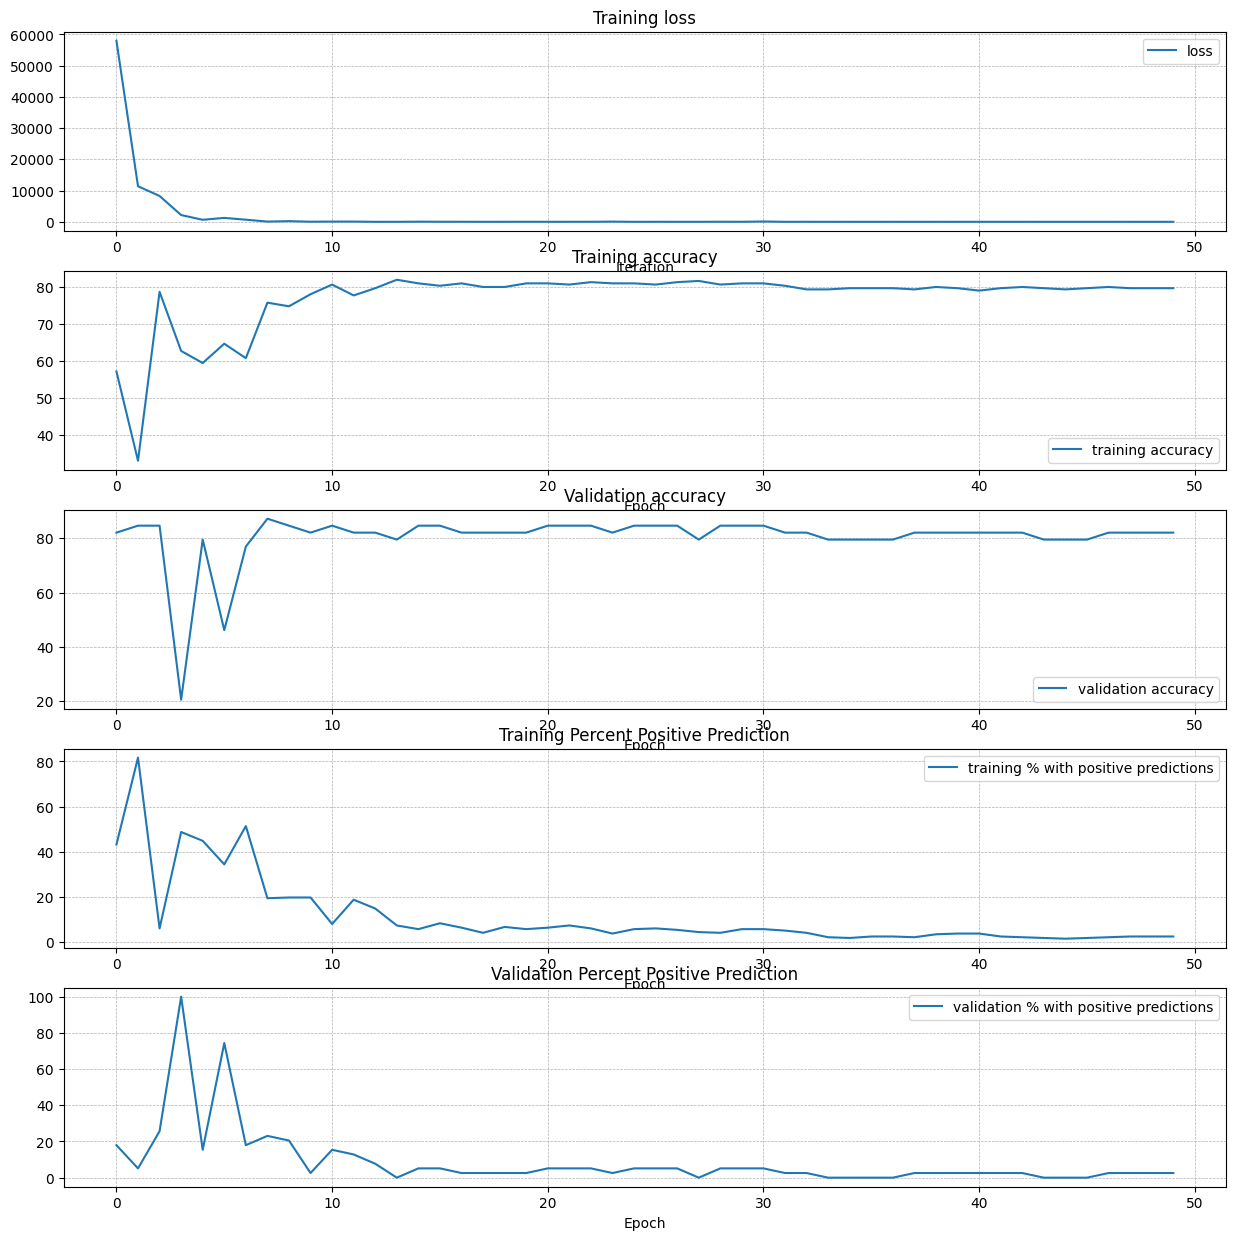

Finished running for lr: 0.01, hidden size: 1000, epochs: 50
Epoch 0, loss = 368308.9375, train_acc = 48.6928, val_acc = 79.4872, train_pos = 46.4052, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 4894.3169, train_acc = 78.4314, val_acc = 84.6154, train_pos = 12.0915, val_pos = 20.5128
Epoch 10, Average Validation F1 Score: 0.625
Epoch 20, loss = 1.4158, train_acc = 80.3922, val_acc = 84.6154, train_pos = 6.8627, val_pos = 5.1282
Epoch 20, Average Validation F1 Score: 0.4
Epoch 30, loss = 1.1760, train_acc = 79.0850, val_acc = 79.4872, train_pos = 1.6340, val_pos = 0.0000
Epoch 30, Average Validation F1 Score: 0.0
Epoch 40, loss = 1.0494, train_acc = 79.7386, val_acc = 82.0513, train_pos = 2.2876, val_pos = 2.5641
Epoch 40, Average Validation F1 Score: 0.2222222222222222
Epoch 50, loss = 0.9279, train_acc = 79.4118, val_acc = 79.4872, train_pos = 2.6144, val_pos = 0.0000
Epoch 50, Average Validation F1 Score: 0.0
Epoch 60, loss = 0.9297, train_acc = 79.738

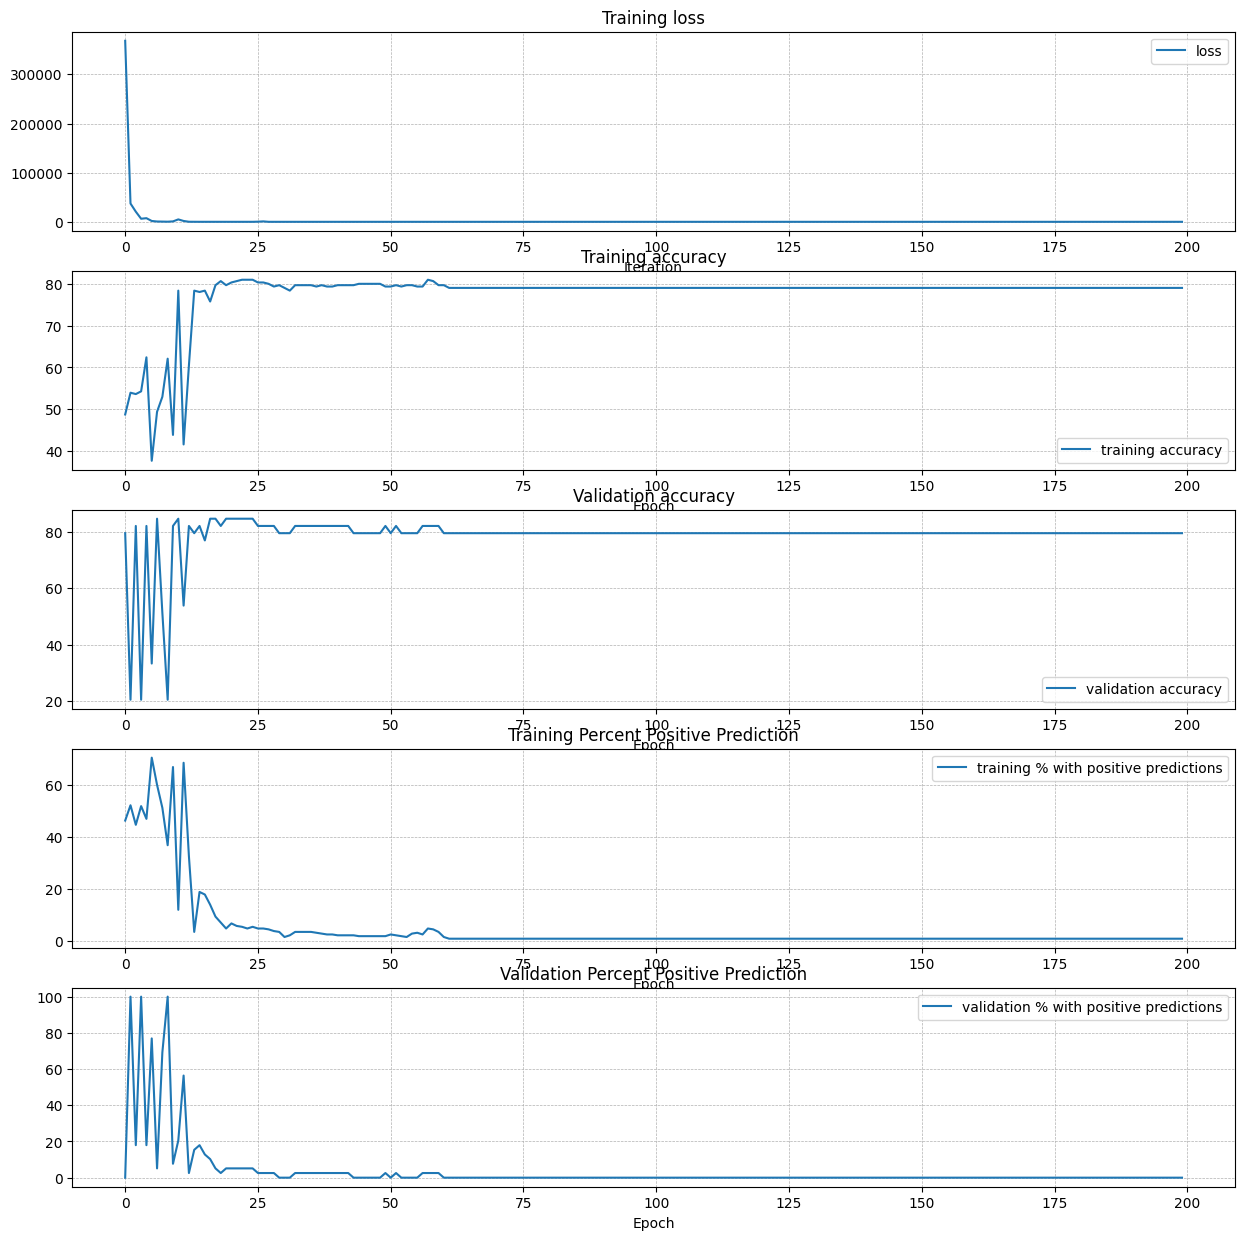

Finished running for lr: 0.01, hidden size: 1000, epochs: 200
Epoch 0, loss = 35.9648, train_acc = 54.5752, val_acc = 30.7692, train_pos = 50.3268, val_pos = 79.4872
Epoch 0, Average Validation F1 Score: 0.30769230769230765
Epoch 10, loss = 1.8518, train_acc = 81.6993, val_acc = 35.8974, train_pos = 22.5490, val_pos = 64.1026
Epoch 10, Average Validation F1 Score: 0.24242424242424243
Epoch 20, loss = 4.3624, train_acc = 72.5490, val_acc = 48.7179, train_pos = 34.3137, val_pos = 56.4103
Epoch 20, Average Validation F1 Score: 0.3333333333333333
Epoch 30, loss = 1.1713, train_acc = 91.5033, val_acc = 58.9744, train_pos = 26.4706, val_pos = 41.0256
Epoch 30, Average Validation F1 Score: 0.3333333333333333
Epoch 40, loss = 0.0169, train_acc = 96.0784, val_acc = 79.4872, train_pos = 25.1634, val_pos = 20.5128
Epoch 40, Average Validation F1 Score: 0.5


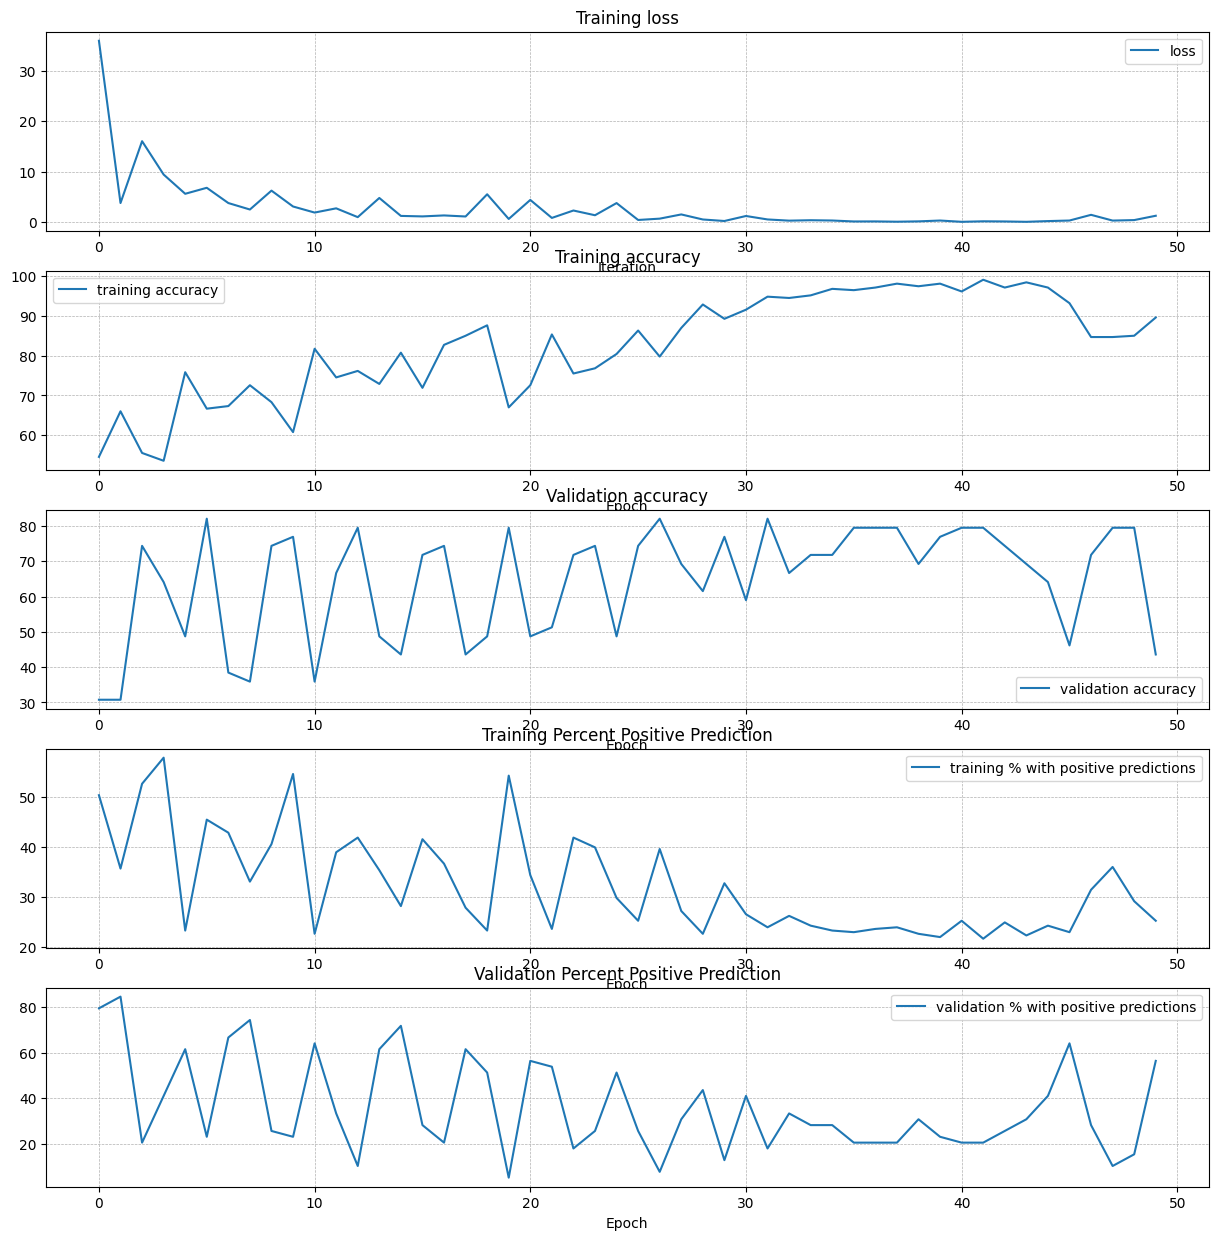

Finished running for lr: 1e-06, hidden size: 2000, epochs: 50
Epoch 0, loss = 51.5107, train_acc = 45.0980, val_acc = 74.3590, train_pos = 59.1503, val_pos = 5.1282
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 2.0266, train_acc = 80.0654, val_acc = 66.6667, train_pos = 28.7582, val_pos = 48.7179
Epoch 10, Average Validation F1 Score: 0.5185185185185185
Epoch 20, loss = 0.2012, train_acc = 92.4837, val_acc = 71.7949, train_pos = 23.5294, val_pos = 28.2051
Epoch 20, Average Validation F1 Score: 0.4210526315789474
Epoch 30, loss = 0.2392, train_acc = 96.4052, val_acc = 69.2308, train_pos = 22.2222, val_pos = 35.8974
Epoch 30, Average Validation F1 Score: 0.45454545454545453
Epoch 40, loss = 0.0532, train_acc = 98.6928, val_acc = 76.9231, train_pos = 22.5490, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.3076923076923077
Epoch 50, loss = 0.0462, train_acc = 98.3660, val_acc = 69.2308, train_pos = 22.2222, val_pos = 35.8974
Epoch 50, Average Validation F1 Score: 0

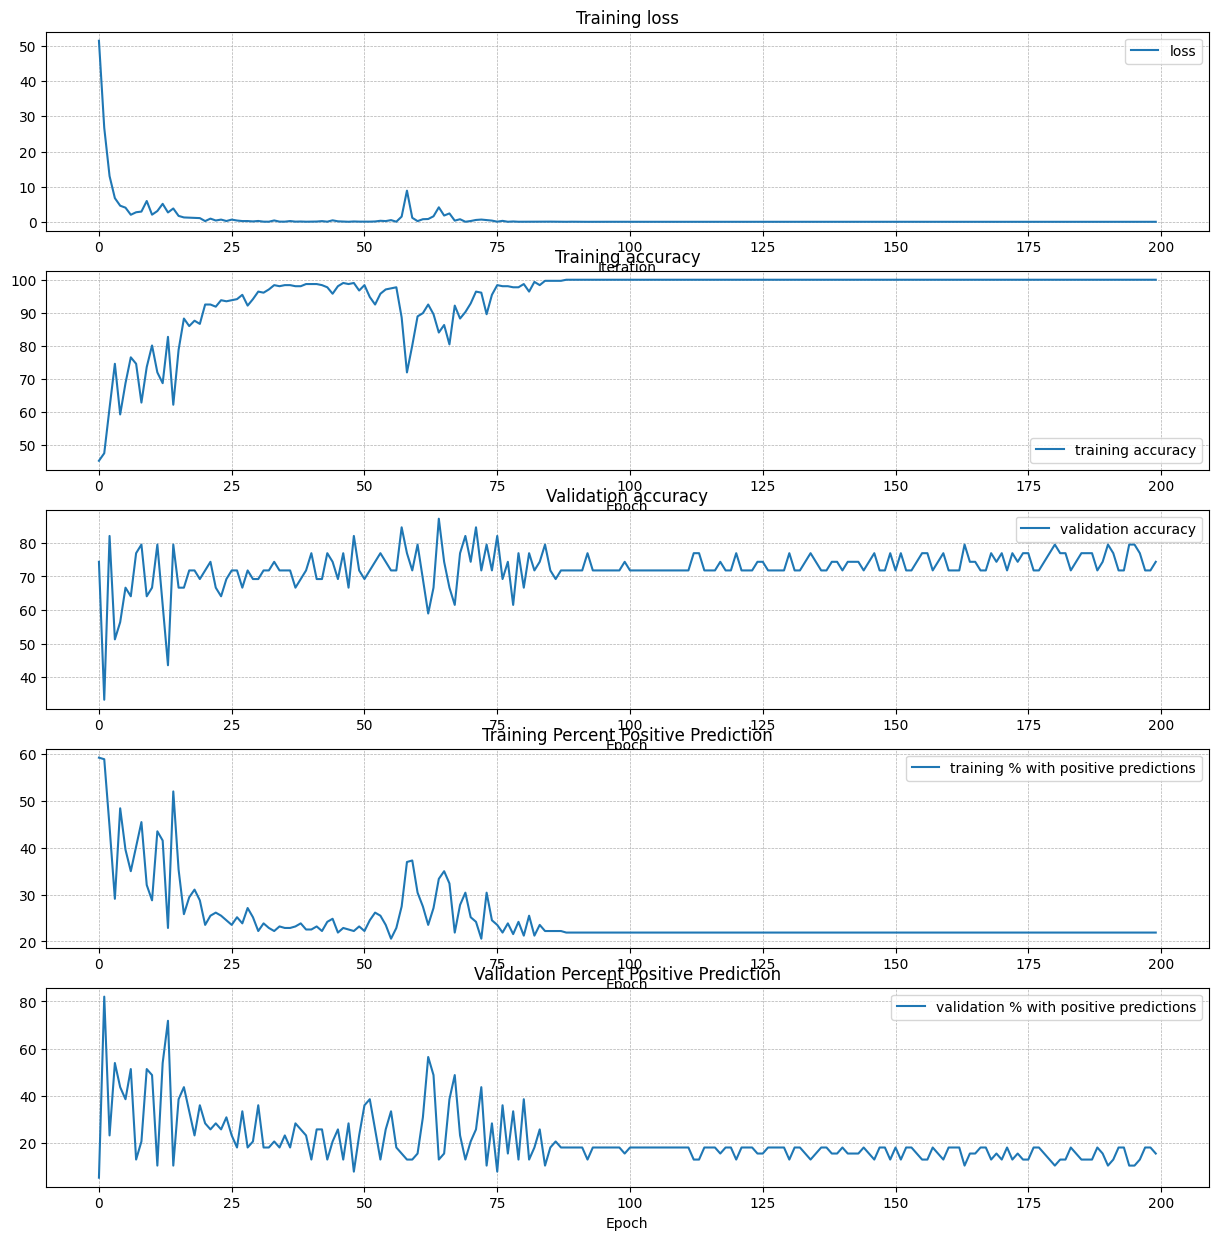

Finished running for lr: 1e-06, hidden size: 2000, epochs: 200
Epoch 0, loss = 383.2917, train_acc = 31.0458, val_acc = 69.2308, train_pos = 79.0850, val_pos = 41.0256
Epoch 0, Average Validation F1 Score: 0.5
Epoch 10, loss = 6.4370, train_acc = 75.4902, val_acc = 61.5385, train_pos = 35.2941, val_pos = 38.4615
Epoch 10, Average Validation F1 Score: 0.3478260869565218
Epoch 20, loss = 6.8449, train_acc = 74.1830, val_acc = 84.6154, train_pos = 35.9477, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 5.3924, train_acc = 80.3922, val_acc = 66.6667, train_pos = 33.6601, val_pos = 43.5897
Epoch 30, Average Validation F1 Score: 0.48
Epoch 40, loss = 4.1957, train_acc = 70.2614, val_acc = 79.4872, train_pos = 41.8301, val_pos = 5.1282
Epoch 40, Average Validation F1 Score: 0.2


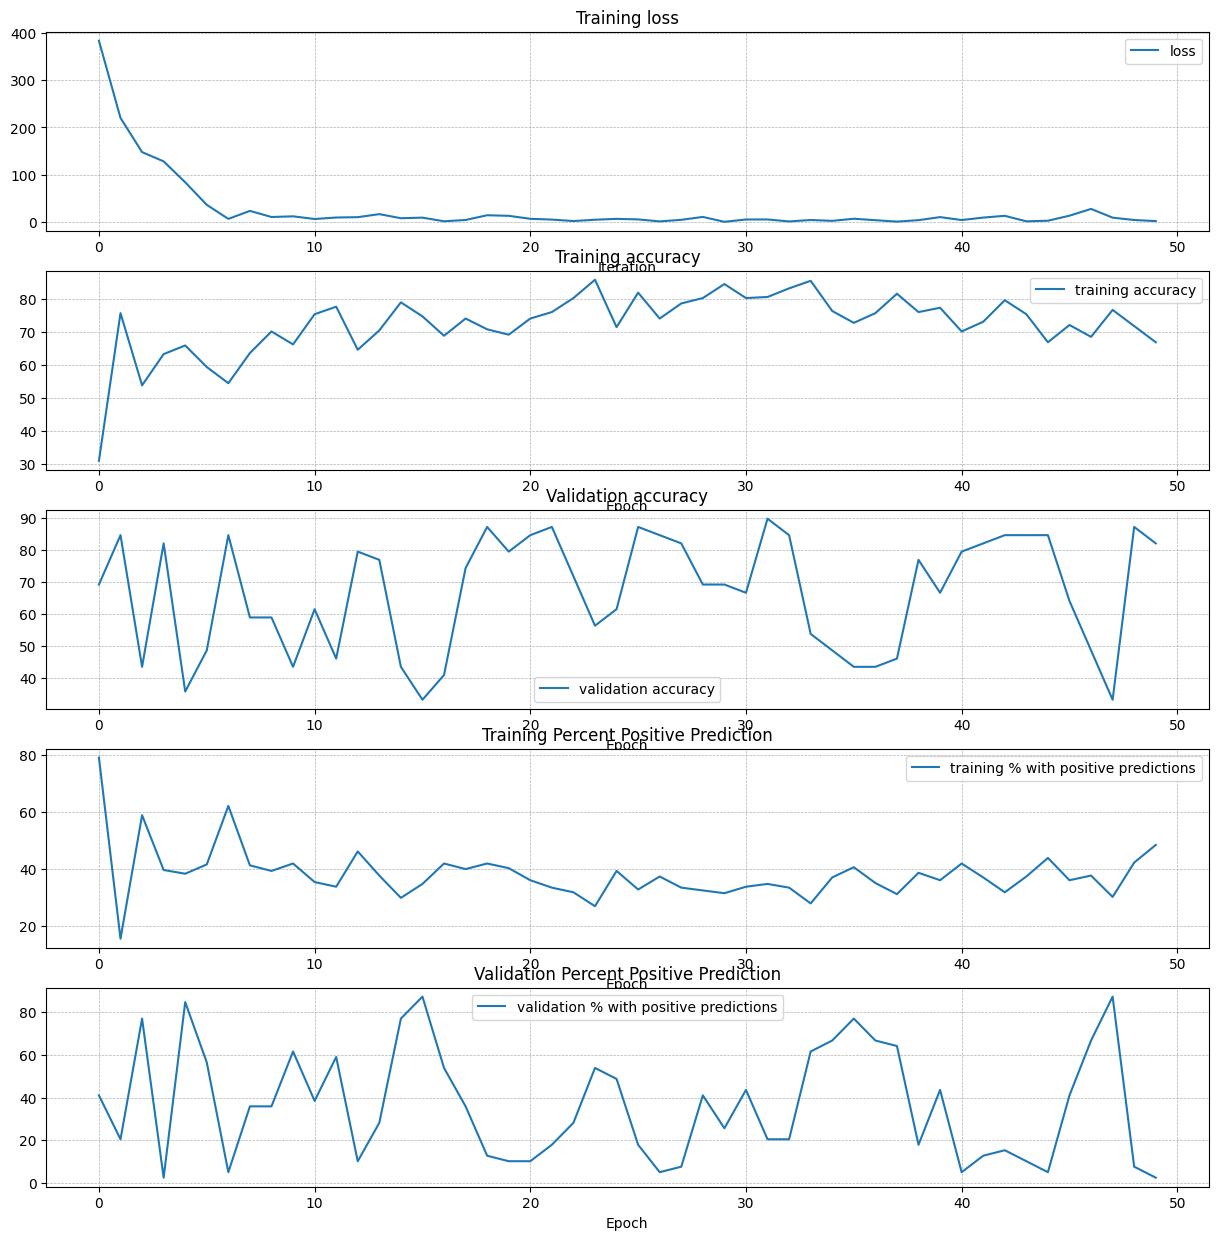

Finished running for lr: 1e-05, hidden size: 2000, epochs: 50
Epoch 0, loss = 136.9586, train_acc = 41.1765, val_acc = 82.0513, train_pos = 72.2222, val_pos = 12.8205
Epoch 0, Average Validation F1 Score: 0.4615384615384615
Epoch 10, loss = 11.4099, train_acc = 73.5294, val_acc = 71.7949, train_pos = 35.9477, val_pos = 33.3333
Epoch 10, Average Validation F1 Score: 0.4761904761904762
Epoch 20, loss = 3.5280, train_acc = 75.1634, val_acc = 69.2308, train_pos = 38.8889, val_pos = 46.1538
Epoch 20, Average Validation F1 Score: 0.5384615384615385
Epoch 30, loss = 0.3548, train_acc = 86.9281, val_acc = 82.0513, train_pos = 29.0850, val_pos = 28.2051
Epoch 30, Average Validation F1 Score: 0.631578947368421
Epoch 40, loss = 1.3367, train_acc = 81.6993, val_acc = 82.0513, train_pos = 33.6601, val_pos = 7.6923
Epoch 40, Average Validation F1 Score: 0.36363636363636365
Epoch 50, loss = 6.2769, train_acc = 78.4314, val_acc = 30.7692, train_pos = 31.0458, val_pos = 84.6154
Epoch 50, Average Valida

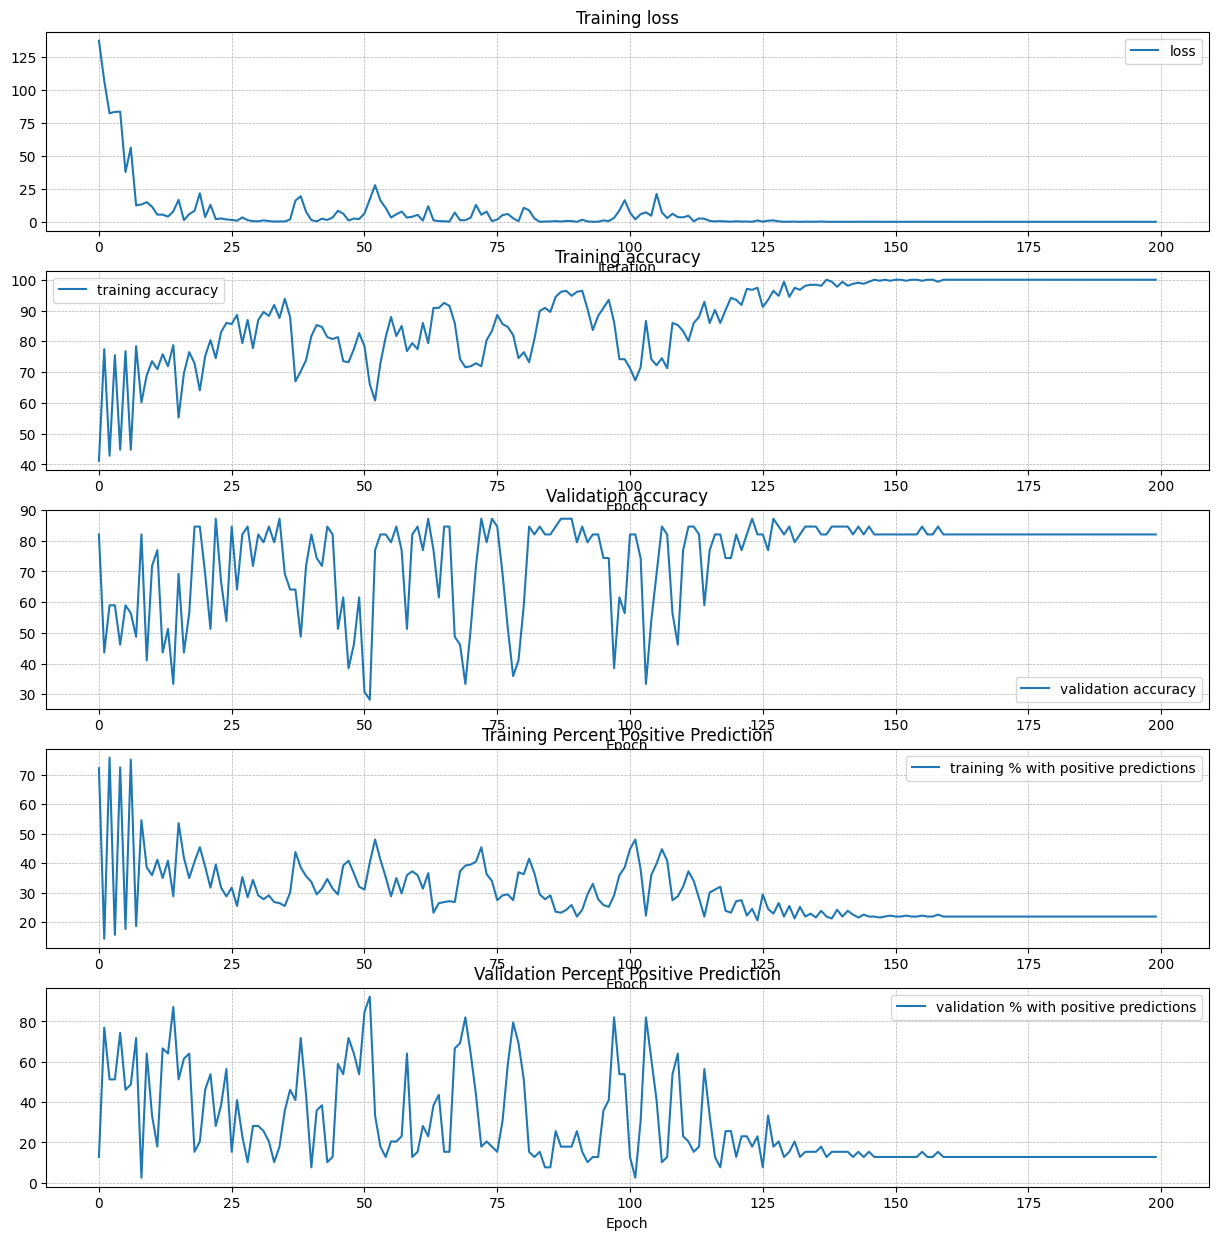

Finished running for lr: 1e-05, hidden size: 2000, epochs: 200
Epoch 0, loss = 1773.1469, train_acc = 58.1699, val_acc = 61.5385, train_pos = 41.5033, val_pos = 48.7179
Epoch 0, Average Validation F1 Score: 0.44444444444444436
Epoch 10, loss = 55.7525, train_acc = 66.6667, val_acc = 82.0513, train_pos = 44.7712, val_pos = 17.9487
Epoch 10, Average Validation F1 Score: 0.5333333333333333
Epoch 20, loss = 11.5269, train_acc = 80.3922, val_acc = 66.6667, train_pos = 34.3137, val_pos = 48.7179
Epoch 20, Average Validation F1 Score: 0.5185185185185185
Epoch 30, loss = 37.2405, train_acc = 80.3922, val_acc = 87.1795, train_pos = 34.3137, val_pos = 17.9487
Epoch 30, Average Validation F1 Score: 0.6666666666666666
Epoch 40, loss = 178.3067, train_acc = 68.9542, val_acc = 58.9744, train_pos = 39.2157, val_pos = 56.4103
Epoch 40, Average Validation F1 Score: 0.4666666666666667


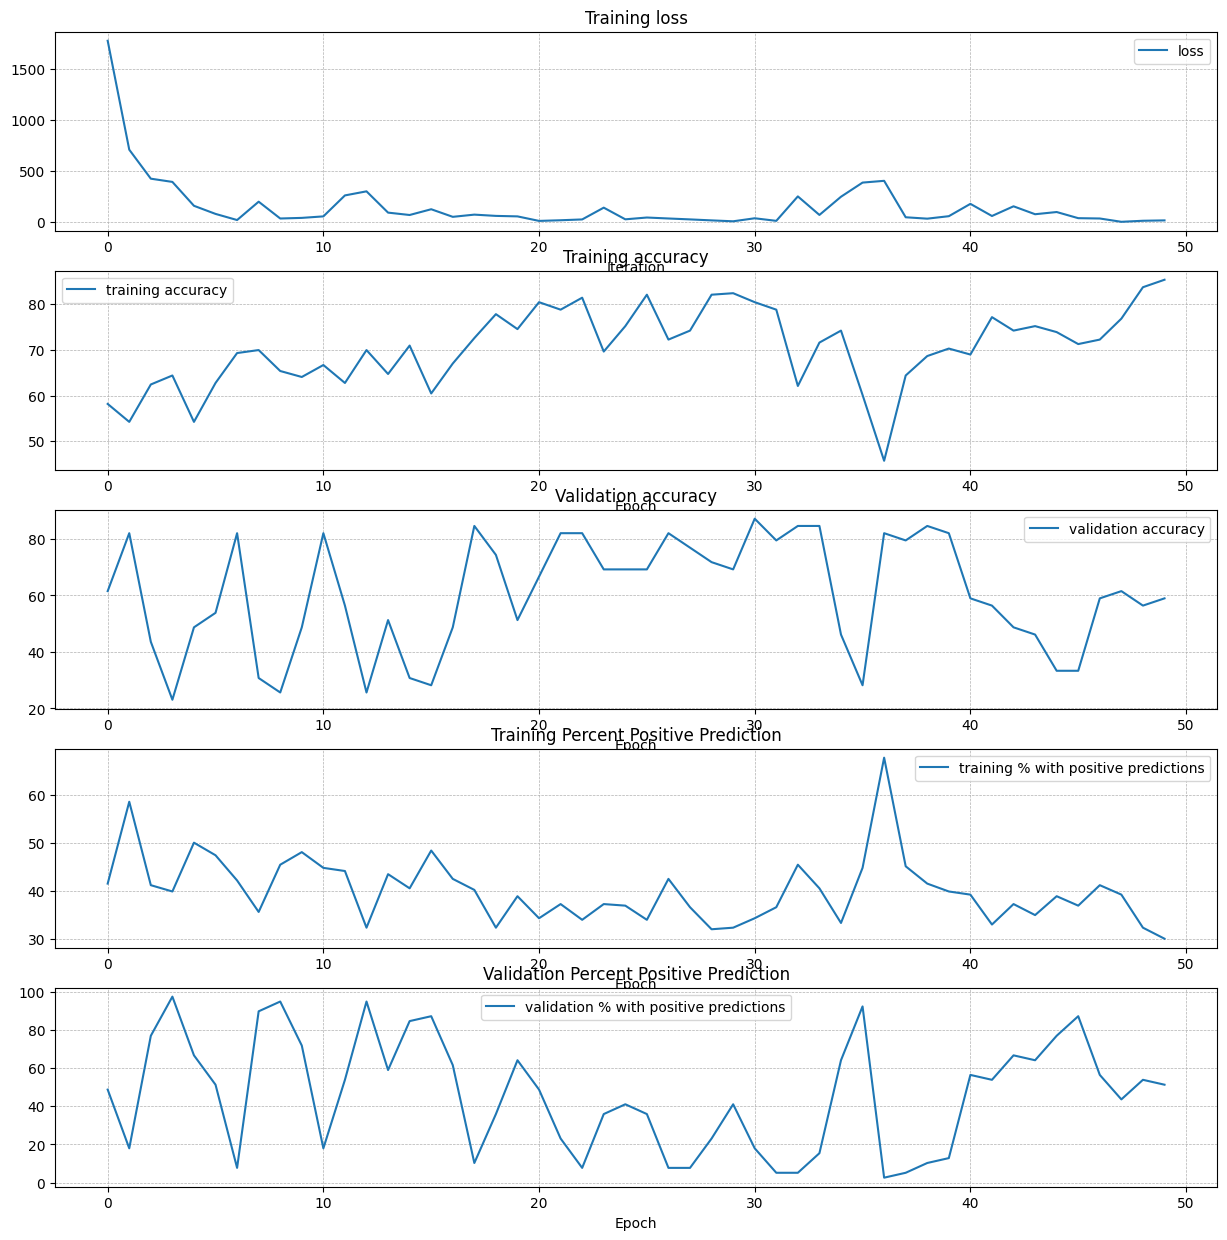

Finished running for lr: 0.0001, hidden size: 2000, epochs: 50
Epoch 0, loss = 88.1473, train_acc = 60.7843, val_acc = 20.5128, train_pos = 35.6209, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 9.8712, train_acc = 49.6732, val_acc = 82.0513, train_pos = 57.8431, val_pos = 2.5641
Epoch 10, Average Validation F1 Score: 0.2222222222222222
Epoch 20, loss = 3.2661, train_acc = 70.9150, val_acc = 82.0513, train_pos = 43.1373, val_pos = 7.6923
Epoch 20, Average Validation F1 Score: 0.36363636363636365
Epoch 30, loss = 1.3044, train_acc = 78.4314, val_acc = 82.0513, train_pos = 35.6209, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.4615384615384615
Epoch 40, loss = 0.5615, train_acc = 87.9085, val_acc = 79.4872, train_pos = 28.1046, val_pos = 30.7692
Epoch 40, Average Validation F1 Score: 0.6
Epoch 50, loss = 0.9058, train_acc = 88.5621, val_acc = 41.0256, train_pos = 28.7582, val_pos = 69.2308
Epoch 50, Average Validation F1 Score: 

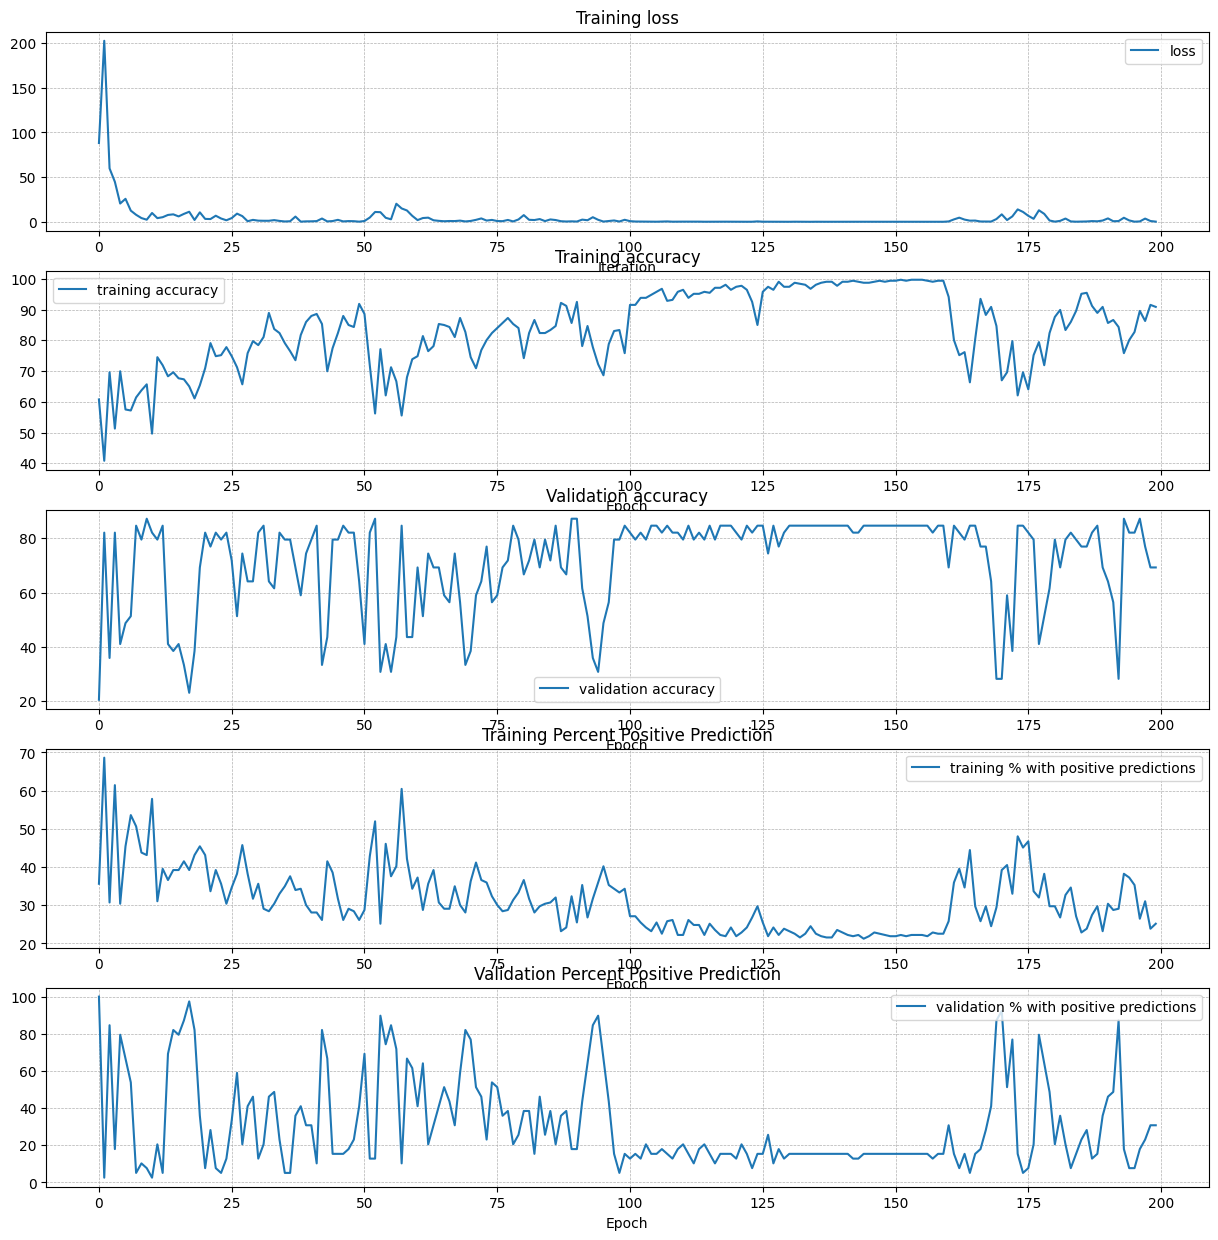

Finished running for lr: 0.0001, hidden size: 2000, epochs: 200
Epoch 0, loss = 5708.7100, train_acc = 42.8105, val_acc = 20.5128, train_pos = 58.1699, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 139.3103, train_acc = 65.3595, val_acc = 43.5897, train_pos = 39.5425, val_pos = 71.7949
Epoch 10, Average Validation F1 Score: 0.3888888888888889
Epoch 20, loss = 17.8755, train_acc = 71.2418, val_acc = 82.0513, train_pos = 36.9281, val_pos = 17.9487
Epoch 20, Average Validation F1 Score: 0.5333333333333333
Epoch 30, loss = 59.2794, train_acc = 64.7059, val_acc = 87.1795, train_pos = 49.3464, val_pos = 17.9487
Epoch 30, Average Validation F1 Score: 0.6666666666666666
Epoch 40, loss = 18.2044, train_acc = 71.8954, val_acc = 48.7179, train_pos = 38.8889, val_pos = 66.6667
Epoch 40, Average Validation F1 Score: 0.411764705882353


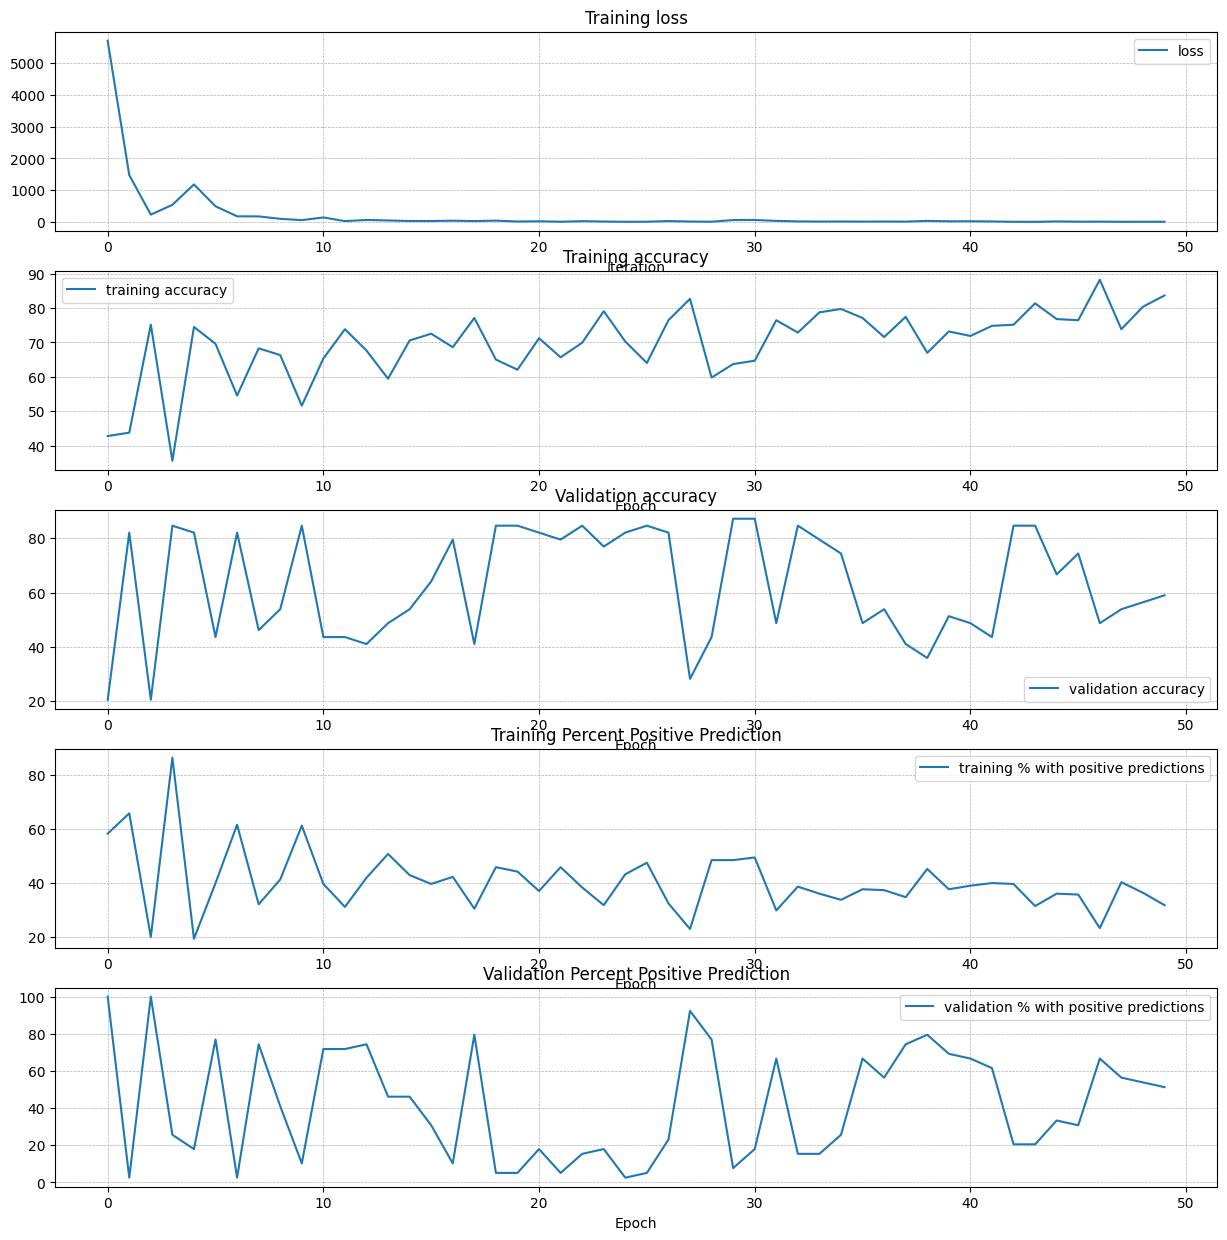

Finished running for lr: 0.001, hidden size: 2000, epochs: 50
Epoch 0, loss = 12646.6543, train_acc = 56.2092, val_acc = 82.0513, train_pos = 49.3464, val_pos = 2.5641
Epoch 0, Average Validation F1 Score: 0.2222222222222222
Epoch 10, loss = 250.9810, train_acc = 63.7255, val_acc = 87.1795, train_pos = 48.3660, val_pos = 7.6923
Epoch 10, Average Validation F1 Score: 0.5454545454545454
Epoch 20, loss = 66.1807, train_acc = 72.2222, val_acc = 48.7179, train_pos = 39.8693, val_pos = 66.6667
Epoch 20, Average Validation F1 Score: 0.411764705882353
Epoch 30, loss = 15.4121, train_acc = 64.0523, val_acc = 69.2308, train_pos = 49.3464, val_pos = 41.0256
Epoch 30, Average Validation F1 Score: 0.5
Epoch 40, loss = 4.9480, train_acc = 61.7647, val_acc = 79.4872, train_pos = 52.2876, val_pos = 5.1282
Epoch 40, Average Validation F1 Score: 0.2
Epoch 50, loss = 3.6394, train_acc = 75.8170, val_acc = 53.8462, train_pos = 38.2353, val_pos = 56.4103
Epoch 50, Average Validation F1 Score: 0.39999999999

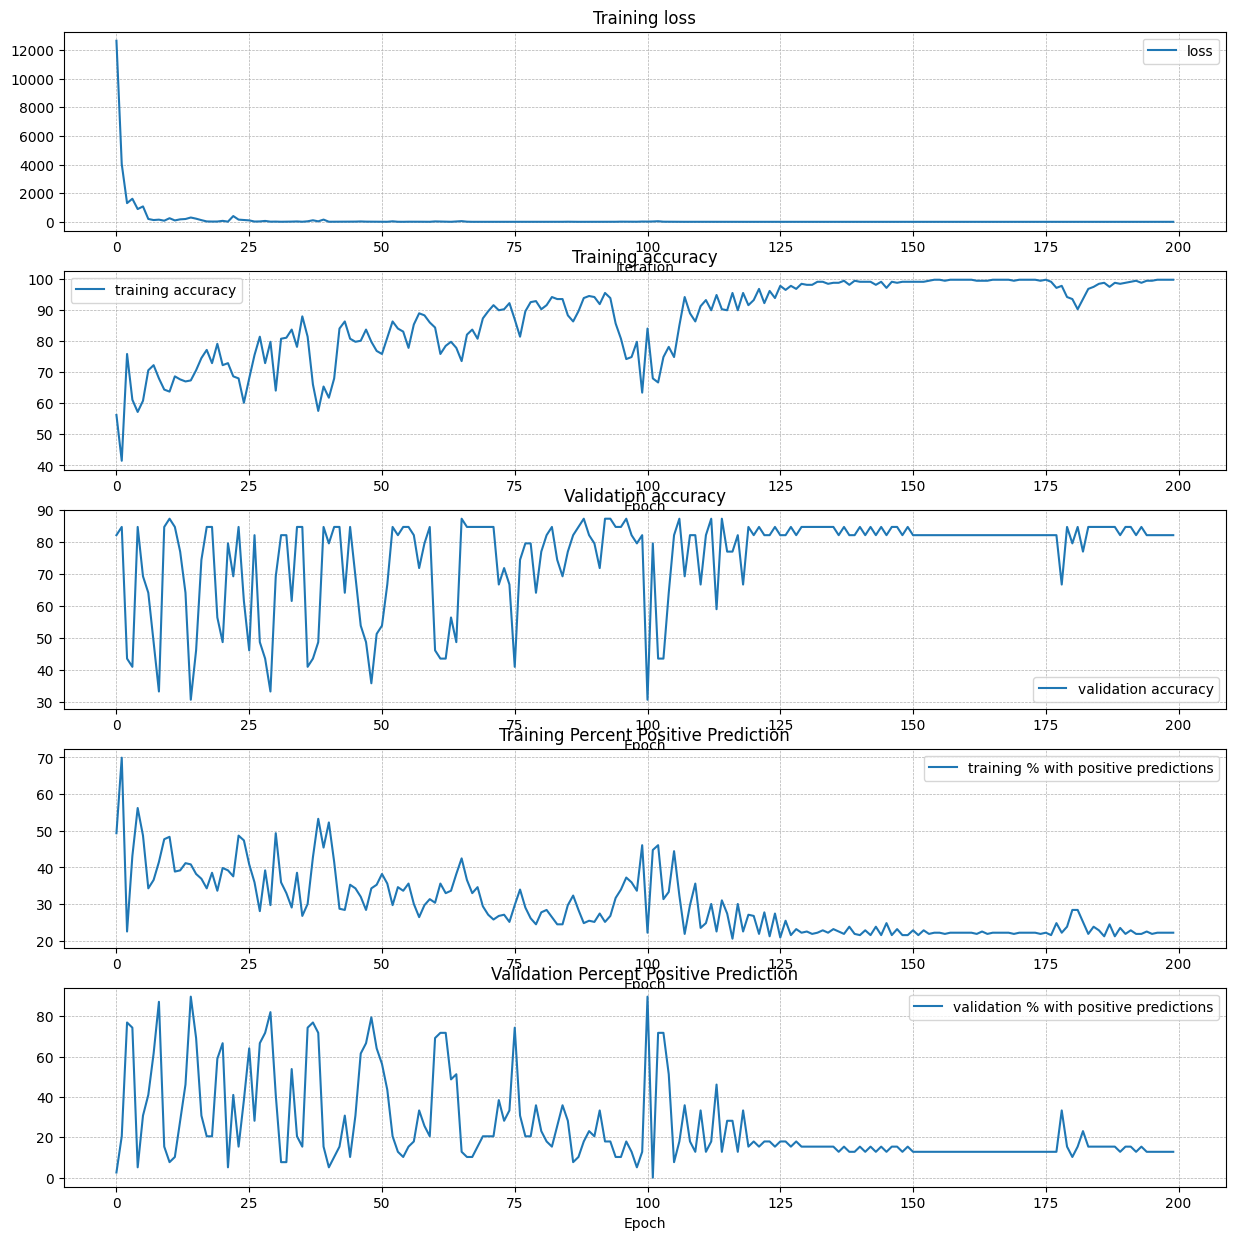

Finished running for lr: 0.001, hidden size: 2000, epochs: 200
Epoch 0, loss = 112169.3672, train_acc = 67.9739, val_acc = 20.5128, train_pos = 23.2026, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 99.3503, train_acc = 65.6863, val_acc = 82.0513, train_pos = 26.7974, val_pos = 7.6923
Epoch 10, Average Validation F1 Score: 0.36363636363636365
Epoch 20, loss = 57.2378, train_acc = 80.3922, val_acc = 84.6154, train_pos = 9.4771, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 5.0762, train_acc = 81.0458, val_acc = 84.6154, train_pos = 5.5556, val_pos = 5.1282
Epoch 30, Average Validation F1 Score: 0.4
Epoch 40, loss = 0.8563, train_acc = 81.6993, val_acc = 84.6154, train_pos = 6.2092, val_pos = 5.1282
Epoch 40, Average Validation F1 Score: 0.4


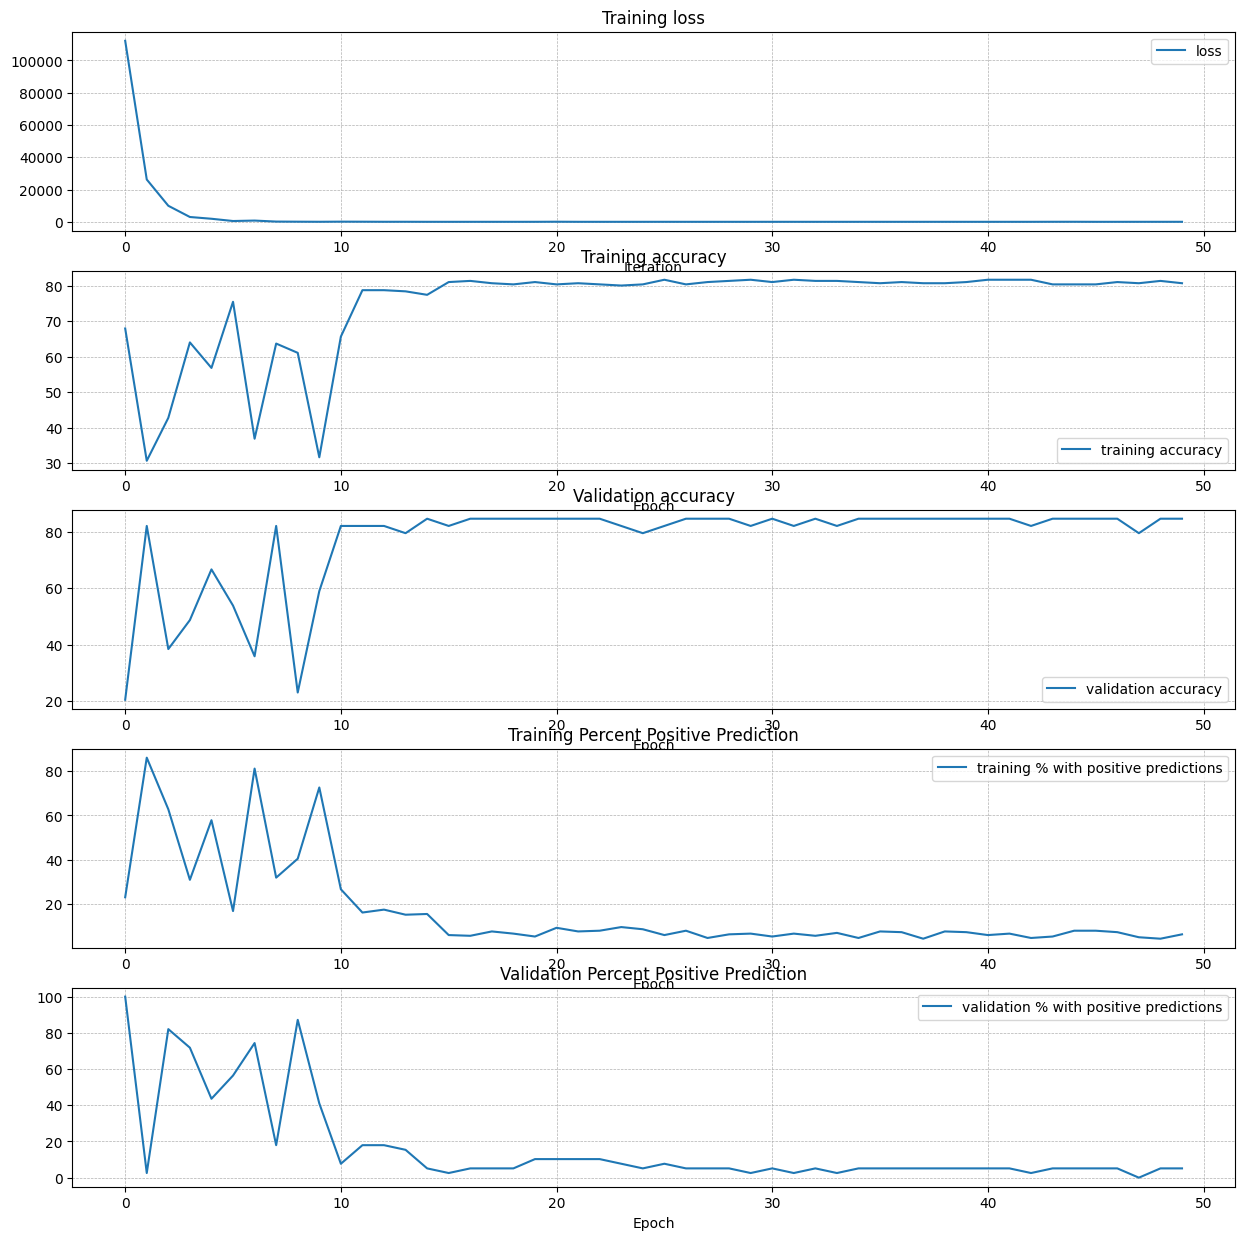

Finished running for lr: 0.01, hidden size: 2000, epochs: 50
Epoch 0, loss = 192598.3125, train_acc = 52.6144, val_acc = 84.6154, train_pos = 41.8301, val_pos = 20.5128
Epoch 0, Average Validation F1 Score: 0.625
Epoch 10, loss = 1.2195, train_acc = 78.7582, val_acc = 79.4872, train_pos = 1.3072, val_pos = 0.0000
Epoch 10, Average Validation F1 Score: 0.0
Epoch 20, loss = 0.8647, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 20, Average Validation F1 Score: 0.0
Epoch 30, loss = 1.0088, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 30, Average Validation F1 Score: 0.0
Epoch 40, loss = 1.2744, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 40, Average Validation F1 Score: 0.0
Epoch 50, loss = 1.0850, train_acc = 78.7582, val_acc = 79.4872, train_pos = 0.6536, val_pos = 0.0000
Epoch 50, Average Validation F1 Score: 0.0
Epoch 60, loss = 0.9363, train_acc = 78.7582, val_acc = 79.487

In [ ]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 51374

hidden_sizes = [100, 1000, 2000, 5000, 10000]
lrs = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
epochs = [50, 200]
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
num_classes = 1

best_model = None
best_val = 0
accuracies = {}

for hidden_size in hidden_sizes:
    for lr in lrs: 
        for num_epochs in epochs:

            model = Barebones_model(input_size, hidden_size, num_classes)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=num_epochs, \
                use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg, verbose=False)

            fig, axes = plt.subplots(5, 1, figsize=(15, 15))

            axes[0].set_title('Training loss')
            axes[0].set_xlabel('Iteration')
            axes[1].set_title('Training accuracy')
            axes[1].set_xlabel('Epoch')
            axes[2].set_title('Validation accuracy')
            axes[2].set_xlabel('Epoch')
            axes[3].set_title('Training Percent Positive Prediction')
            axes[3].set_xlabel('Epoch')
            axes[4].set_title('Validation Percent Positive Prediction')
            axes[4].set_xlabel('Epoch')

            axes[0].plot(loss, label="loss")
            axes[1].plot(train_acc, label="training accuracy")
            axes[2].plot(val_acc, label="validation accuracy")
            axes[3].plot(train_pos, label="training % with positive predictions")
            axes[4].plot(val_pos, label="validation % with positive predictions")

            for ax in axes:
                ax.legend(loc='best', ncol=4)
                ax.grid(linestyle='--', linewidth=0.5)

            plt.show()

            if best_val < val_acc[-1]:
                best_val = val_acc[-1]
                best_model = model
            
            accuracies["lr: {}, hidden size: {}, epochs: {}".format(lr, hidden_size, num_epochs)] = val_acc[-1]
            print("Finished running for lr: {}, hidden size: {}, epochs: {}".format(lr, hidden_size, num_epochs))

In [ ]:
best_model

In [ ]:
print(check_accuracy(loader_val, best_model))
print(check_accuracy(loader_test, best_model))

In [ ]:
# best: 'lr: 1e-05, hidden size: 1000, epochs: 200': 87.17948717948718
accuracies

In [ ]:
plot_roc_curve(best_model, loader_val, device)